In [1466]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import bs4
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time

import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'none'


import shap

## Create Model

In [1467]:
modeling_df = pd.read_csv('data/ncaa_tournament_modeling_df.csv')
modeling_df.head()

,index,Season,Round,Team_1,Team_2,Win,Team_1_Score,Team_2_Score,Team_1_Seed,Team_2_Seed,...,NetRtg_kenpom_1,ORtg_kenpom_1,DRtg_kenpom_1,AdjT_kenpom_1,Luck_kenpom_1,NetRtg_kenpom_2,ORtg_kenpom_2,DRtg_kenpom_2,AdjT_kenpom_2,Luck_kenpom_2
0,0,2010,1,Kentucky,ETSU,True,100,71,1,16,...,26.54,114.9,88.3,68.3,0.060,2.47,100.9,98.4,66.8,-0.004
1,1,2010,1,Texas,Wake Forest,False,80,81,8,9,...,20.75,113.9,93.1,71.5,-0.014,14.12,107.1,93.0,68.7,0.067
2,2,2010,1,Temple,Cornell,False,65,78,5,12,...,20.12,107.8,87.7,60.4,0.076,15.92,117.4,101.5,63.9,0.068
3,3,2010,1,Wisconsin,Wofford,True,53,49,4,13,...,23.56,115.2,91.6,59.2,-0.013,10.12,104.6,94.4,63.5,-0.023
4,4,2010,1,Marquette,Washington,False,78,80,6,11,...,19.65,115.1,95.5,62.3,-0.064,18.19,111.7,93.6,71.7,0.029


In [1468]:
features = modeling_df.columns[7:]
features = [x for x in features if x not in ['G_1', 'W_1', 'L_1', 'G_2', 'W_2', 'L_2', 'Team_1_Seed', 'Team_2_Seed']]
target='Win'
modeling_df['Seed_Diff'] = modeling_df['Team_1_Seed'] - modeling_df['Team_2_Seed']

modeling_df['four_factors_1'] = modeling_df['eFG%_1'] + modeling_df['TOV_1'] - modeling_df['ORB_1'] + modeling_df['FT_1']
modeling_df['four_factors_2'] = modeling_df['eFG%_2'] + modeling_df['TOV_2'] - modeling_df['ORB_2'] + modeling_df['FT_2']
modeling_df['four_factors_diff'] = modeling_df['four_factors_1'] - modeling_df['four_factors_2']

modeling_df['net_efg'] = modeling_df['eFG%_1'] - modeling_df['eFG%_2']

modeling_df['net_pace'] = modeling_df['Pace_1'] - modeling_df['Pace_2']

modeling_df['net_pts_1']= modeling_df['Tm._1']-modeling_df['Opp._1']
modeling_df['net_pts_2']= modeling_df['Tm._2']-modeling_df['Opp._2']
modeling_df['net_pts_diff']= modeling_df['net_pts_1']-modeling_df['net_pts_2']

modeling_df['net_net_rtg']=modeling_df['NetRtg_kenpom_1']-modeling_df['NetRtg_kenpom_2']
modeling_df['net_off_rtg']=modeling_df['ORtg_kenpom_1']-modeling_df['ORtg_kenpom_2']
modeling_df['net_d_rtg']=modeling_df['DRtg_kenpom_1']-modeling_df['DRtg_kenpom_2']
modeling_df['h2h_rtg_1']=modeling_df['ORtg_kenpom_1']-modeling_df['DRtg_kenpom_2']
modeling_df['h2h_rtg_2']=modeling_df['ORtg_kenpom_2']-modeling_df['DRtg_kenpom_1']

# Create rolling tournament win features
# First, create a copy of the dataframe with just the necessary columns
tournament_results = modeling_df[['Season', 'Round','Team_1', 'Team_2', 'Win', 'Team_1_Seed', 'Team_2_Seed']].copy()

# Create a dataframe to track wins by team and season
team_wins_by_season = pd.DataFrame(columns=['Team', 'Season', 'Wins'])

# Process Team_1 wins
team1_wins = tournament_results[tournament_results['Win'] == True][['Season', 'Team_1']]
team1_wins = team1_wins.rename(columns={'Team_1': 'Team'})
team1_wins['Wins'] = 1
team1_wins = team1_wins.groupby(['Team', 'Season']).sum().reset_index()

# Process Team_2 wins
team2_wins = tournament_results[tournament_results['Win'] == False][['Season', 'Team_2']]
team2_wins = team2_wins.rename(columns={'Team_2': 'Team'})
team2_wins['Wins'] = 1
team2_wins = team2_wins.groupby(['Team', 'Season']).sum().reset_index()

# Combine the wins
team_wins_by_season = pd.concat([team1_wins, team2_wins]).groupby(['Team', 'Season']).sum().reset_index()

# Create a function to calculate rolling 3-year tournament wins
def calculate_rolling_tournament_wins(team, season):
    previous_seasons = [season-1, season-2, season-3]
    wins = team_wins_by_season[(team_wins_by_season['Team'] == team) & 
                              (team_wins_by_season['Season'].isin(previous_seasons))]['Wins'].sum()
    return wins

# Apply the function to create rolling tournament win features
rolling_wins = []
for _, row in modeling_df.iterrows():
    team1_rolling_wins = calculate_rolling_tournament_wins(row['Team_1'], row['Season'])
    team2_rolling_wins = calculate_rolling_tournament_wins(row['Team_2'], row['Season'])
    rolling_wins.append({
        'Rolling_3yr_Tournament_Wins_1': team1_rolling_wins,
        'Rolling_3yr_Tournament_Wins_2': team2_rolling_wins,
        'Rolling_3yr_Tournament_Wins_diff': team1_rolling_wins - team2_rolling_wins
    })

# Add the rolling win features to the modeling dataframe
rolling_wins_df = pd.DataFrame(rolling_wins)
modeling_df = pd.concat([modeling_df, rolling_wins_df], axis=1)

# Create features for rolling 3-year wins as Team_1 and Team_2 separately
# First, create dataframes to track wins as Team_1 and Team_2 by team and season
team1_wins_by_season = pd.DataFrame(columns=['Team', 'Season', 'Wins_as_Team1'])
team2_wins_by_season = pd.DataFrame(columns=['Team', 'Season', 'Wins_as_Team2'])

# Process Team_1 wins (when Team_1 wins)
team1_as_team1_wins = tournament_results[tournament_results['Win'] == True][['Season', 'Team_1']]
team1_as_team1_wins = team1_as_team1_wins.rename(columns={'Team_1': 'Team'})
team1_as_team1_wins['Wins_as_Team1'] = 1
team1_as_team1_wins = team1_as_team1_wins.groupby(['Team', 'Season']).sum().reset_index()

# Process Team_2 wins (when Team_1 loses)
team2_as_team2_wins = tournament_results[tournament_results['Win'] == False][['Season', 'Team_2']]
team2_as_team2_wins = team2_as_team2_wins.rename(columns={'Team_2': 'Team'})
team2_as_team2_wins['Wins_as_Team2'] = 1
team2_as_team2_wins = team2_as_team2_wins.groupby(['Team', 'Season']).sum().reset_index()

# Combine into respective dataframes
team1_wins_by_season = team1_as_team1_wins
team2_wins_by_season = team2_as_team2_wins

# Create functions to calculate rolling 3-year tournament wins as Team_1 and Team_2
def calculate_rolling_team1_wins(team, season):
    previous_seasons = [season-1, season-2, season-3]
    wins = team1_wins_by_season[(team1_wins_by_season['Team'] == team) & 
                              (team1_wins_by_season['Season'].isin(previous_seasons))]['Wins_as_Team1'].sum()
    return wins

def calculate_rolling_team2_wins(team, season):
    previous_seasons = [season-1, season-2, season-3]
    wins = team2_wins_by_season[(team2_wins_by_season['Team'] == team) & 
                              (team2_wins_by_season['Season'].isin(previous_seasons))]['Wins_as_Team2'].sum()
    return wins

# Apply the functions to create rolling tournament win features by team position
rolling_position_wins = []
for _, row in modeling_df.iterrows():
    team1_rolling_team1_wins = calculate_rolling_team1_wins(row['Team_1'], row['Season'])
    team1_rolling_team2_wins = calculate_rolling_team2_wins(row['Team_1'], row['Season'])
    team2_rolling_team1_wins = calculate_rolling_team1_wins(row['Team_2'], row['Season'])
    team2_rolling_team2_wins = calculate_rolling_team2_wins(row['Team_2'], row['Season'])
    
    rolling_position_wins.append({
        'Rolling_3yr_Team1_Wins_1': team1_rolling_team1_wins,
        'Rolling_3yr_Team2_Wins_1': team1_rolling_team2_wins,
        'Rolling_3yr_Team1_Wins_2': team2_rolling_team1_wins,
        'Rolling_3yr_Team2_Wins_2': team2_rolling_team2_wins,
        'Rolling_3yr_Team1_Wins_diff': team1_rolling_team1_wins - team2_rolling_team1_wins,
        'Rolling_3yr_Team2_Wins_diff': team1_rolling_team2_wins - team2_rolling_team2_wins
    })

# Add the rolling win by position features to the modeling dataframe
rolling_position_wins_df = pd.DataFrame(rolling_position_wins)
modeling_df = pd.concat([modeling_df, rolling_position_wins_df], axis=1)


# Create a dataframe to track max tournament round by team and season
team_rounds_by_season = pd.DataFrame(columns=['Team', 'Season', 'Max_Round'])

# Process Team_1 rounds
team1_rounds = tournament_results[['Season', 'Team_1', 'Round']]
team1_rounds = team1_rounds.rename(columns={'Team_1': 'Team'})
team1_rounds = team1_rounds.groupby(['Team', 'Season']).max().reset_index()

# Process Team_2 rounds
team2_rounds = tournament_results[['Season', 'Team_2', 'Round']]
team2_rounds = team2_rounds.rename(columns={'Team_2': 'Team'})
team2_rounds = team2_rounds.groupby(['Team', 'Season']).max().reset_index()

# Combine the rounds data
team_rounds_by_season = pd.concat([team1_rounds, team2_rounds]).groupby(['Team', 'Season']).max().reset_index()

# Create a function to calculate rolling 3-year max tournament round
def calculate_rolling_max_tournament_round(team, season):
    previous_seasons = [season-1, season-2, season-3]
    max_round = team_rounds_by_season[(team_rounds_by_season['Team'] == team) & 
                                     (team_rounds_by_season['Season'].isin(previous_seasons))]['Round'].max()
    return max_round if not pd.isna(max_round) else 0

# Apply the function to create rolling max tournament round features
rolling_rounds = []
for _, row in modeling_df.iterrows():
    team1_rolling_max_round = calculate_rolling_max_tournament_round(row['Team_1'], row['Season'])
    team2_rolling_max_round = calculate_rolling_max_tournament_round(row['Team_2'], row['Season'])
    rolling_rounds.append({
        'Max_Tournament_Round_1_rolling': team1_rolling_max_round,
        'Max_Tournament_Round_2_rolling': team2_rolling_max_round,
        'Max_Tournament_Round_diff_rolling': team1_rolling_max_round - team2_rolling_max_round
    })

# Add the rolling max round features to the modeling dataframe
rolling_rounds_df = pd.DataFrame(rolling_rounds)
modeling_df = pd.concat([modeling_df, rolling_rounds_df], axis=1)

# Create a dataframe to track minimum seed by team and season
team_seeds_by_season = pd.DataFrame(columns=['Team', 'Season', 'Min_Seed'])

# Process Team_1 seeds
team1_seeds = tournament_results[['Season', 'Team_1', 'Team_1_Seed']]
team1_seeds = team1_seeds.rename(columns={'Team_1': 'Team', 'Team_1_Seed': 'Seed'})

# Process Team_2 seeds
team2_seeds = tournament_results[['Season', 'Team_2', 'Team_2_Seed']]
team2_seeds = team2_seeds.rename(columns={'Team_2': 'Team', 'Team_2_Seed': 'Seed'})

# Combine the seeds data
team_seeds_by_season = pd.concat([team1_seeds, team2_seeds])
team_seeds_by_season = team_seeds_by_season.groupby(['Team', 'Season']).min().reset_index()

# Create a function to calculate rolling 3-year minimum seed
def calculate_rolling_min_seed(team, season):
    previous_seasons = [season-1, season-2, season-3]
    min_seed = team_seeds_by_season[(team_seeds_by_season['Team'] == team) & 
                                   (team_seeds_by_season['Season'].isin(previous_seasons))]['Seed'].min()
    return min_seed if not pd.isna(min_seed) else 16  # Default to 16 if no tournament appearance

# Apply the function to create rolling minimum seed features
rolling_seeds = []
for _, row in modeling_df.iterrows():
    team1_rolling_min_seed = calculate_rolling_min_seed(row['Team_1'], row['Season'])
    team2_rolling_min_seed = calculate_rolling_min_seed(row['Team_2'], row['Season'])
    rolling_seeds.append({
        'Min_Seed_1_rolling': team1_rolling_min_seed,
        'Min_Seed_2_rolling': team2_rolling_min_seed,
        'Min_Seed_diff_rolling': team1_rolling_min_seed - team2_rolling_min_seed
    })

# Add the rolling minimum seed features to the modeling dataframe
rolling_seeds_df = pd.DataFrame(rolling_seeds)
modeling_df = pd.concat([modeling_df, rolling_seeds_df], axis=1)

# Scale the rolling minimum seed features



In [1469]:
def calculate_game_weight(row):
    round_weights = {
    1: 1.0,      # First Round (Round of 64)
    2: 1.5,      # Second Round (Round of 32)
    3: 2.0,      # Sweet 16
    4: 3.0,      # Elite 8
    5: 4.0,      # Final Four
    6: 5.0       # Championship
    }
    
    # Get round weight
    round_weight = round_weights[row['Round']]
    
    # Calculate upset weight
    if row['Win'] == 1:  # If Team_1 won
        upset_weight = calculate_upset_weight(row['Team_1_Seed'], row['Team_2_Seed'])
    else:  # If Team_2 won
        upset_weight = calculate_upset_weight(row['Team_2_Seed'], row['Team_1_Seed'])
    
    # Combine weights multiplicatively
    combined_weight = .5*round_weight + .5*upset_weight
    
    return combined_weight

def calculate_upset_weight(team1_seed, team2_seed):
    # Assuming team1 is the winner
    seed_diff = team1_seed - team2_seed
    
    if seed_diff > 0:  # If higher seed (underdog) beats lower seed
        # Exponential weighting for bigger upsets
        return 2.0
    else:
        return 1.0  # No upset bonus for favorite winning

In [1470]:


# Load your data
#modeling_df = pd.read_csv(data/'ncaa_tournament_modeling_df.csv').dropna().reset_index(drop=True)
#modeling_df=modeling_df.loc[modeling_df['Season']>2017].reset_index(drop=True).copy()

# Create an upset indicator (when lower seed beats higher seed)
modeling_df['is_upset'] = ((modeling_df['Team_1_Seed'] < modeling_df['Team_2_Seed']-2) & (modeling_df['Win'] == 0)) | \
                         ((modeling_df['Team_1_Seed']-2 > modeling_df['Team_2_Seed']) & (modeling_df['Win'] == 1))

modeling_df['Seed_Diff'] = modeling_df['Team_1_Seed'] - modeling_df['Team_2_Seed']

modeling_df['four_factors_1'] = modeling_df['eFG%_1'] + modeling_df['TOV_1'] - modeling_df['ORB_1'] + modeling_df['FT_1']
modeling_df['four_factors_2'] = modeling_df['eFG%_2'] + modeling_df['TOV_2'] - modeling_df['ORB_2'] + modeling_df['FT_2']
modeling_df['four_factors_diff'] = modeling_df['four_factors_1'] - modeling_df['four_factors_2']

modeling_df['net_efg'] = modeling_df['eFG%_1'] - modeling_df['eFG%_2']

features = modeling_df.columns[7:]
features = [x for x in features if x not in ['G_1', 'W_1', 'L_1', 'G_2', 'W_2', 'L_2', 'Team_1_Seed', 'Team_2_Seed', 'is_upset']]

# Create sample weights (give more importance to upsets)
sample_weights = np.ones(len(modeling_df))
# Weight later rounds more heavily
# Add the weights as new columns
round_weights = {
    1: 1.0,      # First Round (Round of 64)
    2: 1.5,      # Second Round (Round of 32)
    3: 2.0,      # Sweet 16
    4: 3.0,      # Elite 8
    5: 4.0,      # Final Four
    6: 5.0       # Championship
    }
modeling_df['round_weight'] = modeling_df['Round'].map(round_weights)
modeling_df['upset_weight'] = modeling_df.apply(lambda row: calculate_upset_weight(
    row['Team_1_Seed'] if row['Win'] == 1 else row['Team_2_Seed'],
    row['Team_2_Seed'] if row['Win'] == 1 else row['Team_1_Seed']
), axis=1)
modeling_df['combined_weight'] = modeling_df['round_weight'] + modeling_df['upset_weight']*1.2  #Adjust this weight to emphasize upsets more or less

total_df=modeling_df.copy()

holdout_df = modeling_df.loc[modeling_df['Season']<=2017].dropna().reset_index(drop=True).copy()
modeling_df = modeling_df.loc[modeling_df['Season']>2017].dropna().reset_index(drop=True).copy()

# Separate features and target
X = modeling_df[features]
y = modeling_df['Win']
sample_weights = modeling_df['combined_weight']

# Split the data while preserving upset ratio
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42, stratify=modeling_df['is_upset']
)

# Create custom scorer that rewards upset predictions
from sklearn.metrics import make_scorer
def upset_weighted_score(y_true, y_pred, sample_weight=None):
    correct = y_true == y_pred
    # Create upset mask based on original data
    upset_mask = modeling_df['is_upset'].values[y_test.index]
    # Give more weight to correctly predicted upsets
    scores = np.where(upset_mask, 2.0, 1.0) * correct
    return np.average(scores, weights=sample_weight)

upset_scorer = make_scorer(upset_weighted_score)

# # Perform LASSO with cross-validation using custom scorer and sample weights
# lasso_cv = LassoCV(cv=5, random_state=42, max_iter=100000, 
#                    alphas=np.logspace(-4, 0, 100))
# lasso_cv.fit(X_train, y_train, sample_weight=weights_train)

# # Get feature coefficients
# feature_names = X.columns
# coef = pd.Series(lasso_cv.coef_, index=feature_names)

# # Print non-zero coefficients (selected features)
# print("Selected Features:")
# selected_features = coef[coef != 0].sort_values(ascending=False)
# print(selected_features)

# # Visualize feature importance
# plt.figure(figsize=(12, 10))
# sns.barplot(x=selected_features.values, y=selected_features.index)
# plt.title('LASSO Selected Features (Upset-Weighted)')
# plt.xlabel('Coefficient Value')
# plt.tight_layout()
# plt.show()



# # Train logistic regression with selected features
# selected_features = coef[coef != 0]
# X_train_selected = X_train[selected_features.index.values]
# X_test_selected = X_test[selected_features.index.values]

# lr = LogisticRegression(random_state=42, class_weight='balanced')
# lr.fit(X_train_selected, y_train, sample_weight=weights_train)

# # Make predictions
# y_pred = lr.predict(X_test_selected)

# # Analyze upset prediction performance
# test_upsets = modeling_df['is_upset'].values[y_test.index]
# print("\nUpset Prediction Performance:")
# print("Overall Accuracy:", (y_test == y_pred).mean())
# print("Upset Accuracy:", (y_test[test_upsets] == y_pred[test_upsets]).mean())
# print("Non-Upset Accuracy:", (y_test[~test_upsets] == y_pred[~test_upsets]).mean())

# # Print detailed classification report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# # Create confusion matrix with upset labels
# conf_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix (Upset-Weighted Model)')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()

# # Calculate and display feature importance for upset prediction
# upset_importance = pd.DataFrame({
#     'Feature': selected_features.index,
#     'Coefficient': selected_features.values,
#     'Abs_Importance': np.abs(selected_features.values)
# }).sort_values('Abs_Importance', ascending=False)

# print("\nFeature Importance for Upset Prediction:")
# print(upset_importance)

# # Additional analysis: Feature correlation with upsets
# upset_correlations = pd.DataFrame()
# for feature in X.columns:
#     correlation = np.corrcoef(X[feature], modeling_df['is_upset'])[0,1]
#     upset_correlations = upset_correlations.append({
#         'Feature': feature,
#         'Correlation_with_Upsets': correlation
#     }, ignore_index=True)

# print("\nFeature Correlations with Upsets:")
# print(upset_correlations.sort_values('Correlation_with_Upsets', ascending=False))

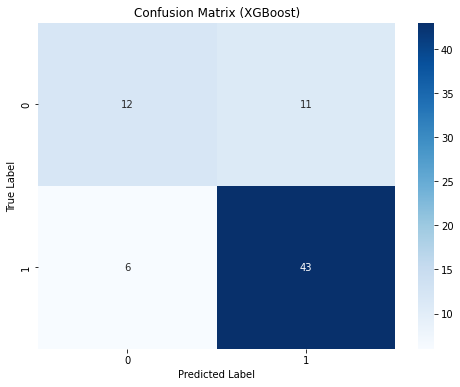

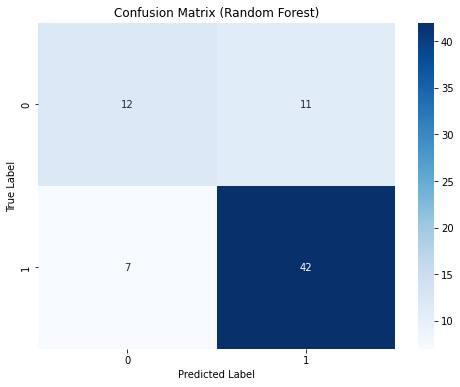

The max_iter was reached which means the coef_ did not converge


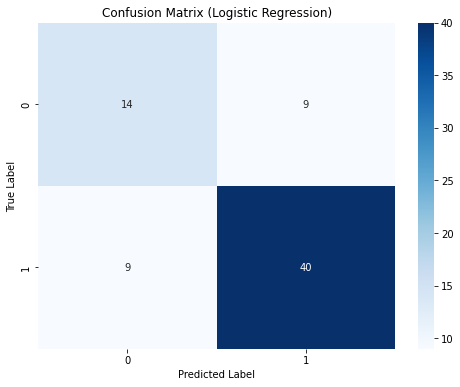

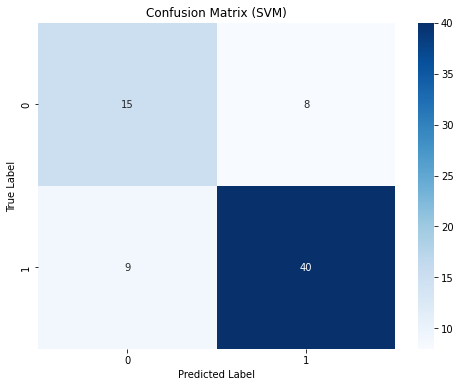

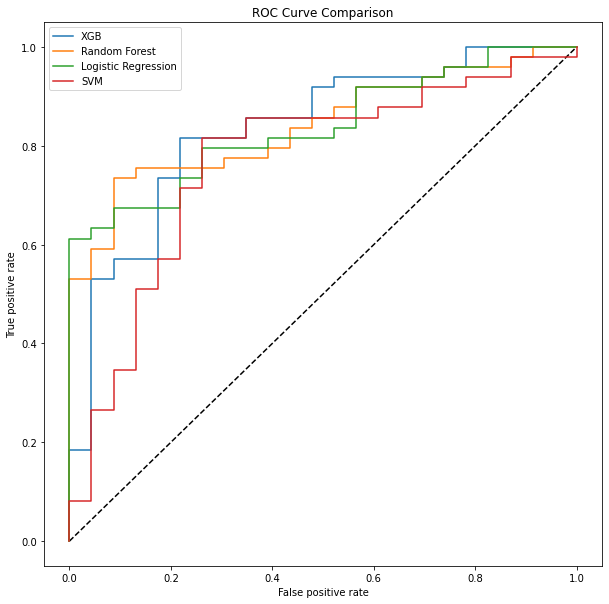

In [1471]:
features = ['W-L%_1',
 '3P_1',
 'TRB_1',
 'AST%_1',
 'Conf. Pct_2',
 'FT%_2',
 'ORB_2',
 'TRB_2',
 'TRB%_2',
 'ORtg_kenpom_1',
 'Luck_kenpom_1',
 'Luck_kenpom_2',
 'Seed_Diff',
 'four_factors_1',
 'net_net_rtg',
 'net_off_rtg',
 'Rolling_3yr_Tournament_Wins_1',
 'Rolling_3yr_Tournament_Wins_diff',
 'Rolling_3yr_Team2_Wins_1']

df_list=[]
scaler_dict={}

upset_mask = abs(modeling_df['Seed_Diff'])>3

# Create a special scaler for rounds 4, 5, and 6 combined
late_rounds = [4, 5, 6]
late_rounds_data = modeling_df.loc[modeling_df['Round'].isin(late_rounds)].copy()
late_rounds_scaler = StandardScaler().fit(late_rounds_data.loc[:, features])

for round in modeling_df['Round'].unique():
    temp = modeling_df.loc[(modeling_df['Round']==round)].copy()
    
    if round in late_rounds:
        # Use the same scaler for rounds 4, 5, and 6
        scaler = late_rounds_scaler
    else:
        # For rounds 1, 2, 3 use individual scalers
        scaler = StandardScaler().fit(temp.loc[:, features])
    
    temp[features] = scaler.transform(temp[features])
    df_list.append(temp)
    scaler_dict[round] = scaler

from pickle import dump, load
with open ('std_scaler.bin', 'wb') as file:
    dump(scaler, file)

modeling_df=pd.concat(df_list)

# Split the data while preserving upset ratio
# Create a new weight array that gives more weight to upsets (Win=False)
upset_weights = sample_weights.copy()
upset_indices = modeling_df['Win'] == False
upset_weights[upset_indices] = upset_weights[upset_indices] * 2  # Double the weight for upsets

x_train, x_test, y_train, y_test, weights_train, weights_test = train_test_split(
    modeling_df[features], modeling_df['Win'], upset_weights, test_size=0.2, random_state=42, stratify=modeling_df['is_upset']
)

XGB = XGBClassifier(use_label_encoder=False,random_state = 0, n_jobs=4, max_depth=2, n_estimators=20, gamma=3,
                     min_child_weight=5, colsample_bytree = .5, subsample=.8, eval_metric='map')
#XGB = RandomForestClassifier(random_state=0, max_depth=3, n_estimators=30, n_jobs=-1, bootstrap=True, max_features=.8)
XGB.fit(x_train[features], y_train, sample_weight=weights_train)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(y_test, XGB.predict_proba(x_test[features])[:,1], drop_intermediate=True)

# Calculate and display confusion matrix for XGB
y_pred_xgb = XGB.predict(x_test[features])
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (XGBoost)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# Create and train Random Forest model
RF = RandomForestClassifier(random_state=42, max_depth=3, n_estimators=30, 
                            n_jobs=4, max_features=0.8, bootstrap=True)
RF.fit(x_train[features], y_train, sample_weight=weights_train)

# Get ROC curve metrics for Random Forest
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, RF.predict_proba(x_test[features])[:,1], drop_intermediate=True)

# Calculate and display confusion matrix for RF
y_pred_rf = RF.predict(x_test[features])
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Create and train Logistic Regression model
LR = LogisticRegression(random_state=0, max_iter=1000,penalty='elasticnet', l1_ratio=0.8, solver='saga')
LR.fit(x_train[features], y_train, sample_weight=weights_train)

# Get ROC curve metrics for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, LR.predict_proba(x_test[features])[:,1], drop_intermediate=True)

# Calculate and display confusion matrix for LR
y_pred_lr = LR.predict(x_test[features])
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



# Create and train SVM model
SVM = SVC(probability=True, random_state=0)
SVM.fit(x_train[features], y_train, sample_weight=weights_train)

# Get ROC curve metrics for SVM
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test, SVM.predict_proba(x_test[features])[:,1], drop_intermediate=True)

# Calculate and display confusion matrix for SVM
y_pred_svm = SVM.predict(x_test[features])
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (SVM)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Update ROC plot to include SVM
plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_xgb, tpr_xgb, label='XGB')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC Curve Comparison')
plt.show()



In [1472]:
# params = {
#         'gamma':[0, 1, 2, 3, 4, 5],
#         'n_estimators':[5, 10, 15, 20],
#         'min_child_weight':[5,10,15,20],
#         'max_depth':[2,3,4]
#         }

# grid = GridSearchCV(estimator=XGB, param_grid=params, n_jobs=-1)

# grid.fit(x_train[features], y_train)

# XGB = grid.best_estimator_

# print(f'Best estimator: {grid.best_estimator_}')
# print(f'\n Best score: {grid.best_score_**.5}')
# print(f'\n Best parameters: {grid.best_params_}')

In [1473]:


class FavoriteModel(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return self  # No fitting necessary

    def predict(self, X):
        return np.ones(X.shape[0], dtype=int)  # Always predict 1

    def predict_proba(self, X):
        return np.array([[0, 1]] * X.shape[0])  # Always predict probability of 1

favorite_model = FavoriteModel()

class WeightedPredictionClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, weights=[0.6, 0.14, 0.14]):
        self.weights = weights

    def fit(self, X, y, XGB_model, LR_model, RF_model):
        self.XGB_model = XGB_model.fit(X, y)
        self.LR_model = LR_model.fit(X, y)
        self.RF_model = RF_model.fit(X, y)
        return self

    def predict_proba(self, X):
        lr_pred = self.LR_model.predict_proba(X)[:,1]
        rf_pred = self.RF_model.predict_proba(X)[:,1]
        xgb_pred = self.XGB_model.predict_proba(X)[:,1]
        
        # Calculate weighted probabilities for class 1
        weighted_prob_1 = (lr_pred * self.weights[1] + 
                          rf_pred * self.weights[2] + 
                          xgb_pred * self.weights[0])
        
        # Create a 2D array with shape (n_samples, 2) where each row is [prob_class_0, prob_class_1]
        result = np.zeros((X.shape[0], 2))
        result[:, 0] = 1 - weighted_prob_1  # Probability for class 0
        result[:, 1] = weighted_prob_1      # Probability for class 1
        
        return result
                
    def predict(self, X):
        weighted_preds = self.predict_proba(X)[:,1]  
        return (weighted_preds > 0.5).astype(int)  # Return 1 if weighted_preds > 0.5, else 0

In [1474]:
features

['W-L%_1',
 '3P_1',
 'TRB_1',
 'AST%_1',
 'Conf. Pct_2',
 'FT%_2',
 'ORB_2',
 'TRB_2',
 'TRB%_2',
 'ORtg_kenpom_1',
 'Luck_kenpom_1',
 'Luck_kenpom_2',
 'Seed_Diff',
 'four_factors_1',
 'net_net_rtg',
 'net_off_rtg',
 'Rolling_3yr_Tournament_Wins_1',
 'Rolling_3yr_Tournament_Wins_diff',
 'Rolling_3yr_Team2_Wins_1']

In [1475]:
modeling_df['is_upset'].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,  15,  16,
            ...
            239, 295, 296, 353, 354,  62, 122, 183, 240, 355],
           dtype='int64', length=356)

In [1476]:
# Get the indices of upset games
upset_indices = modeling_df[modeling_df['is_upset'] == True].index

# Subset X_train to only include rows with indices in upset_indices
X_train_upsets = X_train.loc[X_train.index.intersection(upset_indices)]

In [1477]:
X_train_upsets

,Team_2_Score,W-L%_1,Conf. Pct_1,SRS_1,SOS_1,Tm._1,Opp._1,MP_1,FG_1,FGA_1,...,Rolling_3yr_Team1_Wins_2,Rolling_3yr_Team2_Wins_2,Rolling_3yr_Team1_Wins_diff,Rolling_3yr_Team2_Wins_diff,Max_Tournament_Round_1_rolling,Max_Tournament_Round_2_rolling,Max_Tournament_Round_diff_rolling,Min_Seed_1_rolling,Min_Seed_2_rolling,Min_Seed_diff_rolling
127,73,0.741,0.769231,15.19,7.23,78.111111,68.629630,40.555556,28.740741,59.555556,...,0,0,0,0,0,0,0,16,16,0
291,85,0.676,0.611111,17.30,10.54,77.029412,70.264706,40.147059,25.882353,57.558824,...,2,0,5,0,6,3,3,1,5,-4
210,67,0.722,0.600000,18.90,6.87,83.194444,71.166667,40.277778,29.750000,64.500000,...,0,0,1,1,2,0,2,2,16,-14
97,62,0.657,0.500000,18.07,9.30,76.914286,68.142857,40.000000,27.828571,58.485714,...,1,0,2,0,3,2,1,4,5,-1
45,74,0.912,0.944444,22.20,9.05,67.147059,54.000000,40.147059,24.941176,54.235294,...,0,0,5,0,4,0,4,1,16,-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,61,0.703,0.555556,17.24,10.73,76.756757,70.243243,40.135135,26.972973,57.162162,...,0,0,8,0,5,1,4,1,11,-10
312,75,0.765,0.937500,16.31,3.46,74.000000,59.205882,40.294118,27.529412,59.029412,...,0,0,2,0,2,1,1,5,14,-9
319,72,0.686,0.611111,19.50,10.71,80.400000,71.114286,40.857143,27.628571,57.171429,...,0,0,8,0,6,1,5,1,7,-6
163,65,0.839,0.888889,15.12,1.37,71.032258,56.064516,40.322581,25.935484,52.064516,...,0,0,0,4,5,0,5,11,16,-5


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


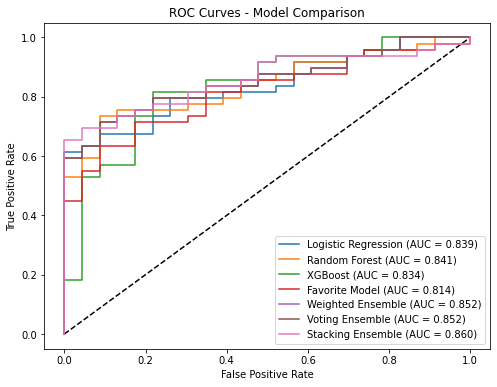

In [1478]:
favorite_model=LogisticRegression().fit(pd.DataFrame(x_train['net_net_rtg']), y_train)

# Get probabilities from each model
lr_probs = LR.predict_proba(x_test[features])[:,1]
rf_probs = RF.predict_proba(x_test[features])[:,1] 
xgb_probs = XGB.predict_proba(x_test[features])[:,1]
favorite_probs = favorite_model.predict_proba(pd.DataFrame(x_test['net_net_rtg']))[:,1]

# Calculate ROC curves and AUC scores for individual models
fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test, lr_probs)
auc_lr = metrics.auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, rf_probs) 
auc_rf = metrics.auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_test, xgb_probs)
auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)

fpr_favorite, tpr_favorite, _ = metrics.roc_curve(y_test, favorite_probs)
auc_favorite = metrics.auc(fpr_favorite, tpr_favorite)

auc_total = auc_xgb+auc_lr+auc_rf
auc_weight_xgb = auc_xgb / auc_total
auc_weight_lr = auc_lr / auc_total
auc_weight_rf = auc_rf / auc_total

# Define the base models
base_models = [
    ('lr', LR),
    ('rf', RF),
    ('xgb', XGB),
    ('svm', SVM),
    #('favorite', favorite_model),
]

voting_clf = VotingClassifier(
    estimators=[('lr', LR), ('rf', RF), ('xgb', XGB)],
    voting='soft',
    weights=[auc_weight_lr, auc_weight_rf, auc_weight_xgb]
)
voting_clf.fit(x_train[features], y_train)


# Create the stacking classifier with logistic regression as the meta-model
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=MLPClassifier(hidden_layer_sizes=(10,10), max_iter=500, random_state=0),
    #final_estimator=XGBClassifier(use_label_encoder=False,random_state = 0, n_jobs=4, max_depth=2, n_estimators=20, gamma=3, min_child_weight=5, colsample_bytree = .5, subsample=.8, eval_metric='map'),
    cv=5
)

# Fit the stacking classifier
stacking_clf.fit(x_train[features], y_train)

# Get predictions from the stacking classifier
stacking_preds = stacking_clf.predict(x_test[features])
stacking_probs = stacking_clf.predict_proba(x_test[features])[:, 1]

# Calculate ROC curve for stacking classifier
fpr_stacking, tpr_stacking, auc_stacking = metrics.roc_curve(y_test, stacking_probs)
auc_stacking = metrics.auc(fpr_stacking, tpr_stacking)


# Calculate weighted probabilities
weighted_prediction = WeightedPredictionClassifier(weights=[auc_weight_xgb, auc_weight_lr, auc_weight_rf])
weighted_prediction.fit(x_train[features], y_train, XGB, LR, RF)
weighted_probs = weighted_prediction.predict_proba(x_test[features])[:,1]

# Calculate ROC curve for weighted predictions
fpr_weighted, tpr_weighted, thresholds_weighted = metrics.roc_curve(y_test, weighted_probs)
auc_weighted = metrics.auc(fpr_weighted, tpr_weighted)

# Get voting classifier probabilities
voting_probs = voting_clf.predict_proba(x_test[features])[:,1]

# Calculate ROC curve for voting classifier
fpr_voting, tpr_voting, _ = metrics.roc_curve(y_test, voting_probs)
auc_voting = metrics.auc(fpr_voting, tpr_voting)



# Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot(fpr_favorite, tpr_favorite, label=f'Favorite Model (AUC = {auc_favorite:.3f})')
plt.plot(fpr_weighted, tpr_weighted, label=f'Weighted Ensemble (AUC = {auc_weighted:.3f})')
plt.plot(fpr_voting, tpr_voting, label=f'Voting Ensemble (AUC = {auc_voting:.3f})')
plt.plot(fpr_stacking, tpr_stacking, label=f'Stacking Ensemble (AUC = {auc_stacking:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.show()


In [1479]:
upset_list

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


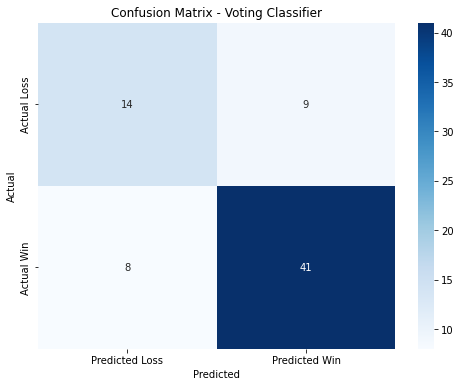

Accuracy: 0.7639
Precision: 0.8200
Recall: 0.8367
F1 Score: 0.8283


In [1480]:
# Create confusion matrix for the voting classifier
#voting_clf = voting_clf.fit(x_train[features], y_train)
voting_clf=stacking_clf.fit(x_train[features], y_train)
#voting_clf=LR.fit(x_train[features], y_train)
voting_preds = voting_clf.predict(x_test[features])
conf_matrix = metrics.confusion_matrix(y_test, voting_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Loss', 'Predicted Win'],
            yticklabels=['Actual Loss', 'Actual Win'])
plt.title('Confusion Matrix - Voting Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Calculate and display classification metrics
print(f"Accuracy: {metrics.accuracy_score(y_test, voting_preds):.4f}")
print(f"Precision: {metrics.precision_score(y_test, voting_preds):.4f}")
print(f"Recall: {metrics.recall_score(y_test, voting_preds):.4f}")
print(f"F1 Score: {metrics.f1_score(y_test, voting_preds):.4f}")


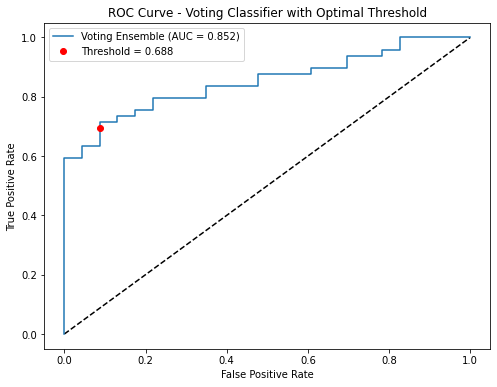

In [1481]:
# Find optimal threshold for voting classifier
fpr, tpr, thresholds = metrics.roc_curve(y_test, voting_probs)
optimal_idx = np.argmax(tpr-fpr)
voting_thresh = thresholds[optimal_idx]

# Get TPR and FPR at optimal threshold
voting_preds = voting_probs > voting_thresh
voting_tpr = metrics.recall_score(y_test, voting_preds)
voting_fpr = 1 - metrics.recall_score(y_test, voting_preds, pos_label=0)

# Plot ROC curve with threshold point
plt.figure(figsize=(8,6))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_voting, tpr_voting, label=f'Voting Ensemble (AUC = {auc_voting:.3f})')
plt.plot(voting_fpr, voting_tpr, 'ro', label=f'Threshold = {voting_thresh:.3f}')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Voting Classifier with Optimal Threshold')
plt.legend()
plt.show()


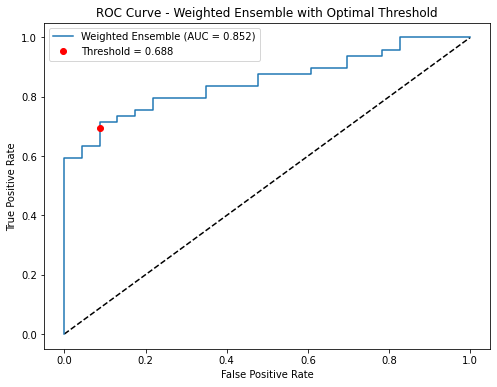

In [1482]:
# Find optimal threshold for voting classifier
fpr, tpr, thresholds = metrics.roc_curve(y_test, weighted_probs)
optimal_idx = np.argmax(tpr-fpr)
weighted_thresh = thresholds[optimal_idx]

# Get TPR and FPR at optimal threshold
weighted_preds = weighted_probs > weighted_thresh
weighted_tpr = metrics.recall_score(y_test, weighted_preds)
weighted_fpr = 1 - metrics.recall_score(y_test, weighted_preds, pos_label=0)

# Plot ROC curve with threshold point
plt.figure(figsize=(8,6))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_weighted, tpr_weighted, label=f'Weighted Ensemble (AUC = {auc_weighted:.3f})')
plt.plot(weighted_fpr, weighted_tpr, 'ro', label=f'Threshold = {weighted_thresh:.3f}')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Weighted Ensemble with Optimal Threshold')
plt.legend()
plt.show()


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


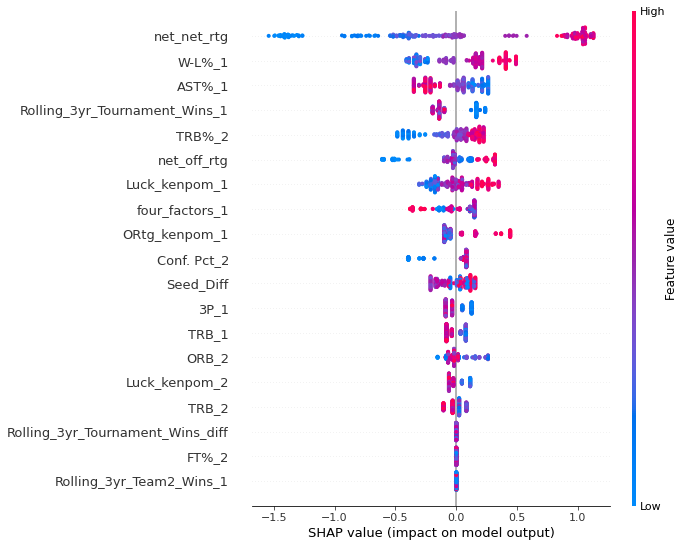

In [1483]:
shapvalues = shap.TreeExplainer(XGB).shap_values(x_train[features])


shap.summary_plot(shapvalues, x_train[features])

In [1484]:
# plot_importance(XGB, max_num_features=10)
# plt.show()

In [1485]:
print(f'Accuracy : {metrics.accuracy_score(y_test, voting_clf.predict(x_test[features])):.1%}')
print(f'Precision : {metrics.precision_score(y_test, voting_clf.predict(x_test[features])):.1%}')
print(f'Recall : {metrics.recall_score(y_test, voting_clf.predict(x_test[features])):.1%}')

Accuracy : 76.4%
Precision : 82.0%
Recall : 83.7%


In [1486]:
# Create a custom scoring function that mimics tournament scoring
def tournament_score(y_true, y_pred_proba, threshold):
    y_pred = y_pred_proba > threshold
    correct = y_true == y_pred
    upset_mask = modeling_df['is_upset'].values[y_test.index]
    round_weights = modeling_df['round_weight'].values[y_test.index]
    
    # Score correctly predicted games with round and upset weights
    scores = np.where(upset_mask, 2.0, 1.0) * correct * round_weights
    return np.sum(scores)

# Try different thresholds
thresholds = np.linspace(0.1, 0.9, 50)
scores = [tournament_score(y_test, voting_probs, t) for t in thresholds]
voting_thresh = thresholds[np.argmax(scores)]

print(f'Accuracy : {metrics.accuracy_score(y_test, voting_clf.predict_proba(x_test[features])[:,1]>voting_thresh):.1%}')
print(f'Precision : {metrics.precision_score(y_test, voting_clf.predict_proba(x_test[features])[:,1]>voting_thresh):.1%}')
print(f'Recall : {metrics.recall_score(y_test, voting_clf.predict_proba(x_test[features])[:,1]>voting_thresh):.1%}')

Accuracy : 76.4%
Precision : 84.8%
Recall : 79.6%


In [1487]:
voting_thresh

0.573469387755102

In [1488]:
modeling_df = modeling_df.dropna()
if 'Prediction' in modeling_df.columns:
    modeling_df = modeling_df.drop(columns='Prediction')
modeling_df.insert(5, 'Prediction', voting_clf.predict_proba(modeling_df[features])[:,1]>voting_thresh)

modeling_df

,index,Season,Round,Team_1,Team_2,Prediction,Win,Team_1_Score,Team_2_Score,Team_1_Seed,...,Max_Tournament_Round_1_rolling,Max_Tournament_Round_2_rolling,Max_Tournament_Round_diff_rolling,Min_Seed_1_rolling,Min_Seed_2_rolling,Min_Seed_diff_rolling,is_upset,round_weight,upset_weight,combined_weight
0,441,2018,1,Villanova,Radford,True,True,87,61,1,...,6,0,6,1,16,-15,False,1.0,1.0,2.2
1,442,2018,1,Virginia Tech,Alabama,False,False,83,86,8,...,1,0,1,9,16,-7,False,1.0,2.0,3.4
2,443,2018,1,West Virginia,Murray State,True,True,85,68,5,...,3,0,3,3,16,-13,False,1.0,1.0,2.2
3,444,2018,1,Wichita State,Marshall,False,False,75,81,4,...,3,0,3,7,16,-9,True,1.0,2.0,3.4
4,445,2018,1,Florida,Bonaventure,False,True,77,62,6,...,4,0,4,4,16,-12,False,1.0,1.0,2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,503,2018,6,Villanova,Michigan,True,True,79,62,1,...,6,3,3,1,7,-6,False,5.0,1.0,6.2
122,566,2019,6,Virginia,Texas Tech,True,True,85,77,1,...,4,4,0,1,3,-2,False,5.0,1.0,6.2
183,628,2021,6,Baylor,Gonzaga,False,True,86,70,1,...,2,4,-2,9,1,8,False,5.0,1.0,6.2
240,691,2022,6,Kansas,UNC,True,True,72,69,1,...,2,3,-1,3,1,2,False,5.0,1.0,6.2


In [1489]:
upsets = modeling_df.loc[((modeling_df['Win']==False) & (modeling_df['Team_1_Seed']<modeling_df['Team_2_Seed']-2)) | ((modeling_df['Win']==True) & (modeling_df['Team_1_Seed']-2>modeling_df['Team_2_Seed'])), :].iloc[:,:6]
(upsets['Prediction']==False).sum()/len(upsets)

0.6419753086419753

In [1490]:
upsets

,index,Season,Round,Team_1,Team_2,Prediction
3,444,2018,1,Wichita State,Marshall,False
6,447,2018,1,Arkansas,Butler,False
34,475,2018,1,TCU,Syracuse,False
45,486,2018,1,Virginia,UMBC,True
48,489,2018,1,Arizona,Buffalo,False
...,...,...,...,...,...,...
137,581,2021,4,Michigan,UCLA,False
255,706,2023,4,Kansas State,Florida Atlantic,False
283,736,2023,4,Texas,Miami,True
352,814,2024,4,Duke,NC State,False


In [1491]:
# Calculate overall accuracy
print(f"Overall Prediction Accuracy: {(modeling_df['Prediction']==modeling_df['Win']).mean():.1%}")

# Break down accuracy by season
accuracy_by_season = modeling_df.groupby('Season').apply(lambda x: (x['Prediction']==x['Win']).mean())
print("\nPrediction Accuracy by Season:")
print(accuracy_by_season)

# Calculate accuracy for predicting upsets
upset_predictions = modeling_df.loc[((modeling_df['Win']==False) & (modeling_df['Team_1_Seed']<modeling_df['Team_2_Seed']-2)) | 
                                  ((modeling_df['Win']==True) & (modeling_df['Team_1_Seed']-2>modeling_df['Team_2_Seed'])), :]

print(f"\nOverall Upset Prediction Accuracy: {(upset_predictions['Prediction']==upset_predictions['Win']).mean():.1%}")

# Break down by season
upset_accuracy_by_season = upset_predictions.groupby('Season').apply(lambda x: (x['Prediction']==x['Win']).mean())
print("\nUpset Prediction Accuracy by Season:")
print(upset_accuracy_by_season)


Overall Prediction Accuracy: 77.5%

Prediction Accuracy by Season:
Season
2018    0.746032
2019    0.933333
2021    0.803279
2022    0.771930
2023    0.607143
2024    0.779661
dtype: float64

Overall Upset Prediction Accuracy: 64.2%

Upset Prediction Accuracy by Season:
Season
2018    0.642857
2019    0.777778
2021    0.588235
2022    0.785714
2023    0.461538
2024    0.642857
dtype: float64


In [1492]:
# Calculate accuracy by round
accuracy_by_round = modeling_df.groupby('Round').apply(lambda x: (x['Prediction']==x['Win']).mean())
print("Prediction Accuracy by Round:")
print(accuracy_by_round)

# Calculate upset accuracy by round
upset_accuracy_by_round = upset_predictions.groupby('Round').apply(lambda x: (x['Prediction']==x['Win']).mean())
print("\nUpset Prediction Accuracy by Round:")
print(upset_accuracy_by_round)


Prediction Accuracy by Round:
Round
1    0.755556
2    0.800000
3    0.723404
4    0.863636
5    0.916667
6    0.800000
dtype: float64

Upset Prediction Accuracy by Round:
Round
1    0.589744
2    0.700000
3    0.625000
4    0.800000
5    1.000000
dtype: float64


In [1493]:
upsets[upsets['Season']==2024].sort_values(by='Round')

,index,Season,Round,Team_1,Team_2,Prediction
299,758,2024,1,Auburn,Yale,True
300,759,2024,1,BYU,Duquesne,False
312,772,2024,1,Saint,Grand Canyon,False
328,789,2024,1,South Carolina,Oregon,False
340,802,2024,1,Wisconsin,James Madison,True
342,804,2024,1,Texas Tech,NC State,False
343,805,2024,1,Kentucky,Oakland,True
344,806,2024,1,Florida,Colorado,False
319,780,2024,2,Baylor,Clemson,False
321,782,2024,3,UNC,Alabama,False


In [1494]:
modeling_df.loc[(modeling_df['Season']==2024)&(modeling_df['Round']==1)&(modeling_df['Win']==True), ['Team_1', 'Team_2', 'Team_1_Seed', 'Team_2_Seed', 'Prediction', 'Win']]

,Team_1,Team_2,Team_1_Seed,Team_2_Seed,Prediction,Win
297,UConn,Stetson,1,16,True,True
301,Illinois,Morehead State,3,14,True,True
302,Washington State,Drake,7,10,True,True
303,Iowa State,South Dakota State,2,15,True,True
310,UNC,Wagner,1,16,True,True
313,Clemson,New Mexico,6,11,False,True
314,Baylor,Colgate,3,14,True,True
315,Dayton,Nevada,7,10,False,True
316,Arizona,Long Beach State,2,15,True,True
324,Purdue,Grambling,1,16,True,True


In [1495]:
# Calculate prediction accuracy by seed difference
modeling_df['Seed_Difference'] = modeling_df['Team_1_Seed'] - modeling_df['Team_2_Seed']
accuracy_by_seed_diff = modeling_df.groupby('Seed_Difference').apply(lambda x: (x['Prediction'] == x['Win']).mean())
seed_diff_counts = modeling_df['Seed_Difference'].value_counts().sort_index()
accuracy_seed_diff = pd.DataFrame({'Seed_Difference': seed_diff_counts.index, 'Count': seed_diff_counts.values, 'Accuracy': accuracy_by_seed_diff.values})
accuracy_seed_diff['Seed_Difference'] = accuracy_seed_diff['Seed_Difference'].abs()
accuracy_seed_diff=accuracy_seed_diff.set_index('Seed_Difference')

print("\nPrediction Accuracy by Seed Difference:")
print(accuracy_seed_diff)



Prediction Accuracy by Seed Difference:
                 Count  Accuracy
Seed_Difference                 
15                  22  0.909091
13                  22  0.909091
12                   1  1.000000
11                  25  0.880000
10                   4  1.000000
9                   29  0.793103
8                   45  0.800000
7                   34  0.705882
6                    3  1.000000
5                   37  0.729730
4                   20  0.750000
3                   48  0.645833
2                   10  1.000000
1                   53  0.716981
0                    3  0.666667


In [1496]:
# Predict probabilities using the existing Logistic Regression model (LR)
modeling_df['LR_Prob'] = LR.predict_proba(modeling_df[features])[:, 1]

# Use threshold of 0.704 for predicting a win
modeling_df['LR_Prediction'] = modeling_df['LR_Prob'] > 0.704

# Calculate accuracy by seed difference for Logistic Regression predictions
accuracy_seed_diff_lr = modeling_df.groupby('Seed_Difference').apply(lambda x: (x['LR_Prediction'] == x['Win']).mean())
seed_diff_counts_lr = modeling_df['Seed_Difference'].value_counts().sort_index()
accuracy_seed_diff_lr = pd.DataFrame({'Seed_Difference': seed_diff_counts_lr.index, 'Count': seed_diff_counts_lr.values, 'Accuracy': accuracy_seed_diff_lr.values})
accuracy_seed_diff_lr['Seed_Difference'] = accuracy_seed_diff_lr['Seed_Difference'].abs()
accuracy_seed_diff_lr = accuracy_seed_diff_lr.set_index('Seed_Difference')

print("\nPrediction Accuracy by Seed Difference (Logistic Regression):")
print(accuracy_seed_diff_lr)




Prediction Accuracy by Seed Difference (Logistic Regression):
                 Count  Accuracy
Seed_Difference                 
15                  22  0.909091
13                  22  0.863636
12                   1  1.000000
11                  25  0.800000
10                   4  1.000000
9                   29  0.827586
8                   45  0.688889
7                   34  0.823529
6                    3  1.000000
5                   37  0.756757
4                   20  0.750000
3                   48  0.625000
2                   10  1.000000
1                   53  0.698113
0                    3  0.666667


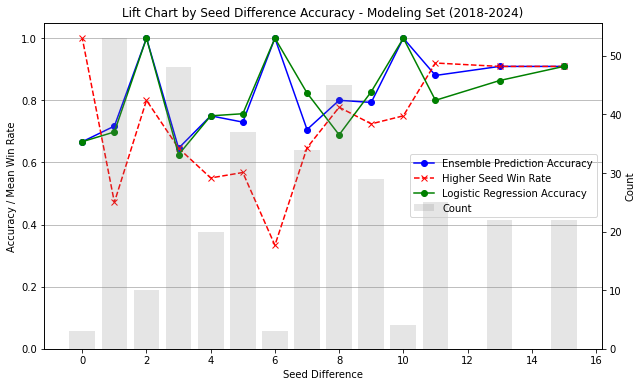

In [1497]:
# Calculate mean win rate by seed difference
mean_win_rate_by_seed_diff = modeling_df.groupby('Seed_Difference')['Win'].mean()
mean_win_rate_by_seed_diff.index = mean_win_rate_by_seed_diff.index.to_series().abs()

# Prepare data for lift chart
lift_data = accuracy_seed_diff.copy()
lift_data['Mean_Win_Rate'] = mean_win_rate_by_seed_diff

lift_data['Accuracy_lr'] = accuracy_seed_diff_lr['Accuracy']

lift_data=lift_data.drop(12)

# Create the lift chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy
ax1.plot(lift_data.index, lift_data['Accuracy'], marker='o', label='Ensemble Prediction Accuracy', color='blue')
ax1.plot(lift_data.index, lift_data['Mean_Win_Rate'], marker='x', label='Higher Seed Win Rate', color='red', linestyle='--')
ax1.plot(lift_data.index, lift_data['Accuracy_lr'], marker='o', label='Logistic Regression Accuracy', color='green')


ax2 = plt.gca().twinx()  # Create a second y-axis
ax2.bar(lift_data.index, lift_data['Count'], color='gray', alpha=0.2, label='Count')
ax2.set_ylabel('Count')


# Add labels and title
ax1.set_title('Lift Chart by Seed Difference Accuracy - Modeling Set (2018-2024)')
ax1.set_xlabel('Seed Difference')
ax1.set_ylabel('Accuracy / Mean Win Rate')
ax1.set_ylim(0,1.05)

fig.legend(loc='center right', bbox_to_anchor=(1, .5), bbox_transform=ax1.transAxes)  # Create a single legend


ax1.yaxis.grid(True)  # Add horizontal gridlines

plt.show()


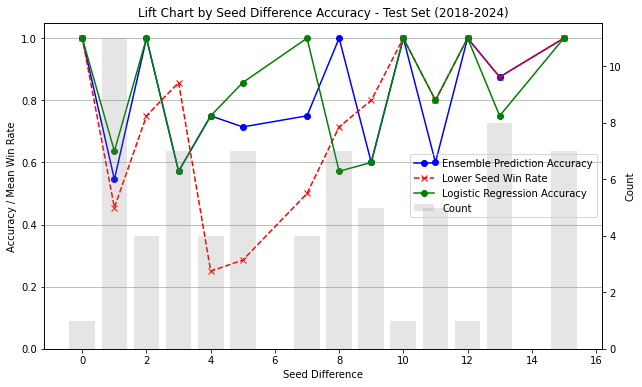

In [1498]:
test_set = modeling_df.loc[x_test.index,:].copy()

# Calculate mean win rate by seed difference
mean_win_rate_by_seed_diff = test_set.groupby('Seed_Difference')['Win'].mean()
mean_win_rate_by_seed_diff.index = mean_win_rate_by_seed_diff.index.to_series().abs()

accuracy_seed_diff_lr = test_set.groupby('Seed_Difference').apply(lambda x: (x['LR_Prediction'] == x['Win']).mean())
seed_diff_counts_lr = test_set['Seed_Difference'].value_counts().sort_index()
accuracy_seed_diff_lr = pd.DataFrame({'Seed_Difference': seed_diff_counts_lr.index, 'Count': seed_diff_counts_lr.values, 'Accuracy': accuracy_seed_diff_lr.values})
accuracy_seed_diff_lr['Seed_Difference'] = accuracy_seed_diff_lr['Seed_Difference'].abs()
accuracy_seed_diff_lr = accuracy_seed_diff_lr.set_index('Seed_Difference')

accuracy_by_seed_diff = test_set.groupby('Seed_Difference').apply(lambda x: (x['Prediction'] == x['Win']).mean())
seed_diff_counts = test_set['Seed_Difference'].value_counts().sort_index()
accuracy_seed_diff = pd.DataFrame({'Seed_Difference': seed_diff_counts.index, 'Count': seed_diff_counts.values, 'Accuracy': accuracy_by_seed_diff.values})
accuracy_seed_diff['Seed_Difference'] = accuracy_seed_diff['Seed_Difference'].abs()
accuracy_seed_diff=accuracy_seed_diff.set_index('Seed_Difference')

# Prepare data for lift chart
lift_data = accuracy_seed_diff.copy()
lift_data['Mean_Win_Rate'] = mean_win_rate_by_seed_diff

lift_data['Accuracy_lr'] = accuracy_seed_diff_lr['Accuracy']

# Create the lift chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy
ax1.plot(lift_data.index, lift_data['Accuracy'], marker='o', label='Ensemble Prediction Accuracy', color='blue')
ax1.plot(lift_data.index, lift_data['Mean_Win_Rate'], marker='x', label='Lower Seed Win Rate', color='red', linestyle='--')
ax1.plot(lift_data.index, lift_data['Accuracy_lr'], marker='o', label='Logistic Regression Accuracy', color='green')


ax2 = plt.gca().twinx()  # Create a second y-axis
ax2.bar(lift_data.index, lift_data['Count'], color='gray', alpha=0.2, label='Count')
ax2.set_ylabel('Count')


# Add labels and title
ax1.set_title('Lift Chart by Seed Difference Accuracy - Test Set (2018-2024)')
ax1.set_xlabel('Seed Difference')
ax1.set_ylabel('Accuracy / Mean Win Rate')
ax1.set_ylim(0,1.05)

fig.legend(loc='center right', bbox_to_anchor=(1, .5), bbox_transform=ax1.transAxes)  # Create a single legend


ax1.yaxis.grid(True)  # Add horizontal gridlines

plt.show()


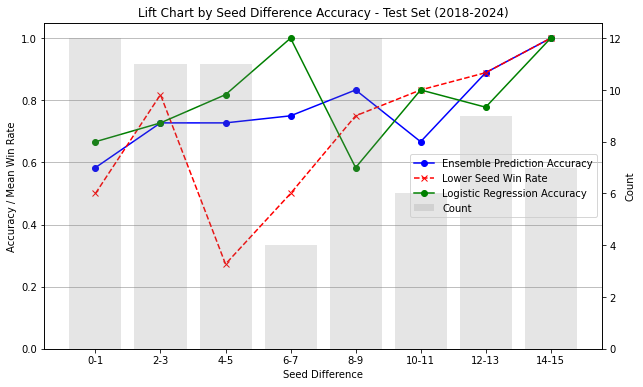

In [1499]:
# Aggregate the data by combining every 2 rows
# Group by seed difference ranges and calculate weighted averages
grouped = lift_data.groupby(lift_data.index // 2)
lift_data_aggregated = pd.DataFrame()
lift_data_aggregated['Accuracy'] = grouped.apply(lambda x: (x['Accuracy'] * x['Count']).sum() / x['Count'].sum())
lift_data_aggregated['Mean_Win_Rate'] = grouped.apply(lambda x: (x['Mean_Win_Rate'] * x['Count']).sum() / x['Count'].sum())
lift_data_aggregated['Accuracy_lr'] = grouped.apply(lambda x: (x['Accuracy_lr'] * x['Count']).sum() / x['Count'].sum())
lift_data_aggregated['Count'] = grouped['Count'].sum()
lift_data_aggregated.index = lift_data_aggregated.index * 2
lift_data_aggregated.index = lift_data_aggregated.index.astype(str) + '-' + (lift_data_aggregated.index + 1).astype(str)

# Create the lift chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy
ax1.plot(lift_data_aggregated.index, lift_data_aggregated['Accuracy'], marker='o', label='Ensemble Prediction Accuracy', color='blue')
ax1.plot(lift_data_aggregated.index, lift_data_aggregated['Mean_Win_Rate'], marker='x', label='Lower Seed Win Rate', color='red', linestyle='--')
ax1.plot(lift_data_aggregated.index, lift_data_aggregated['Accuracy_lr'], marker='o', label='Logistic Regression Accuracy', color='green')


ax2 = plt.gca().twinx()  # Create a second y-axis
ax2.bar(lift_data_aggregated.index, lift_data_aggregated['Count'], color='gray', alpha=0.2, label='Count')
ax2.set_ylabel('Count')


# Add labels and title
ax1.set_title('Lift Chart by Seed Difference Accuracy - Test Set (2018-2024)')
ax1.set_xlabel('Seed Difference')
ax1.set_ylabel('Accuracy / Mean Win Rate')
ax1.set_ylim(0,1.05)

fig.legend(loc='center right', bbox_to_anchor=(1, .5), bbox_transform=ax1.transAxes)  # Create a single legend


ax1.yaxis.grid(True)  # Add horizontal gridlines

plt.show()

In [1500]:
# Assuming holdout_df is already defined and preprocessed
# Ensure the same features are used
df_list=[]
for round in holdout_df['Round'].unique():
    temp=holdout_df.loc[holdout_df['Round']==round].copy()
    scaler = scaler_dict[round]
    temp[features]=scaler.transform(temp[features])
    df_list.append(temp)

holdout_df=pd.concat(df_list)

holdout_features = holdout_df[features]

# Predict probabilities on the holdout set
voting_clf=stacking_clf.fit(modeling_df[features], modeling_df['Win'])
holdout_probs = voting_clf.predict_proba(holdout_features)[:, 1]

# Get predictions based on a threshold (you can use the optimal threshold found earlier)
holdout_preds = holdout_probs > voting_thresh

# Calculate overall accuracy
overall_accuracy = np.mean(holdout_preds == holdout_df['Win'])
print(f"Overall Accuracy: {overall_accuracy:.3f}")

# Calculate accuracy by year
years = holdout_df['Season'].unique()
for year in years:
    year_mask = holdout_df['Season'] == year
    year_accuracy = np.mean(holdout_preds[year_mask] == holdout_df['Win'][year_mask])
    print(f"Accuracy for {year}: {year_accuracy:.3f}")

# Calculate upset accuracy
upset_mask = holdout_df['is_upset']
upset_accuracy = np.mean(holdout_preds[upset_mask] == holdout_df['Win'][upset_mask])
print(f"\nUpset Accuracy: {upset_accuracy:.3f}")


# Calculate upset accuracy by year
upset_accuracy_by_year = holdout_df.groupby('Season').apply(lambda x: np.mean(holdout_preds[x.index][x['is_upset']] == x['Win'][x['is_upset']]))
print("Upset Prediction Accuracy by Year:")
for year, accuracy in upset_accuracy_by_year.items():
    print(f"Upset Accuracy for {year}: {accuracy:.3f}")




Overall Accuracy: 0.769
Accuracy for 2010: 0.707
Accuracy for 2012: 0.719
Accuracy for 2013: 0.852
Accuracy for 2014: 0.778
Accuracy for 2015: 0.850
Accuracy for 2016: 0.776
Accuracy for 2017: 0.710

Upset Accuracy: 0.622
Upset Prediction Accuracy by Year:
Upset Accuracy for 2010: 0.400
Upset Accuracy for 2012: 0.545
Upset Accuracy for 2013: 0.167
Upset Accuracy for 2014: 0.222
Upset Accuracy for 2015: 0.300
Upset Accuracy for 2016: 0.500
Upset Accuracy for 2017: 0.500


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


In [1501]:
# Calculate prediction accuracy by seed difference

holdout_df['Seed_Difference'] = holdout_df['Team_1_Seed'] - holdout_df['Team_2_Seed']
holdout_df['Prediction'] = holdout_preds
accuracy_by_seed_diff = holdout_df.groupby('Seed_Difference').apply(lambda x: (x['Prediction'] == x['Win']).mean())
seed_diff_counts = holdout_df['Seed_Difference'].value_counts().sort_index()
accuracy_seed_diff = pd.DataFrame({'Seed_Difference': seed_diff_counts.index, 'Count': seed_diff_counts.values, 'Accuracy': accuracy_by_seed_diff.values})
accuracy_seed_diff['Seed_Difference'] = accuracy_seed_diff['Seed_Difference'].abs()
accuracy_seed_diff = accuracy_seed_diff.set_index('Seed_Difference')

print("\nPrediction Accuracy by Seed Difference:")
print(accuracy_seed_diff)



Prediction Accuracy by Seed Difference:
                 Count  Accuracy
Seed_Difference                 
15                  21  1.000000
13                  25  0.800000
12                   2  1.000000
11                  27  0.740741
10                   2  1.000000
9                   32  0.875000
8                   46  0.782609
7                   46  0.760870
6                    5  0.800000
5                   43  0.651163
4                   23  0.739130
3                   57  0.771930
2                    5  0.800000
1                   62  0.725806
0                    7  0.571429


In [1502]:
# Predict probabilities using the existing Logistic Regression model (LR)
holdout_df['LR_Prob'] = LR.predict_proba(holdout_df[features])[:, 1]

# Use threshold of 0.704 for predicting a win
holdout_df['LR_Prediction'] = holdout_df['LR_Prob'] > 0.704

# Calculate accuracy by seed difference for Logistic Regression predictions
accuracy_seed_diff_lr = holdout_df.groupby('Seed_Difference').apply(lambda x: (x['LR_Prediction'] == x['Win']).mean())
seed_diff_counts_lr = holdout_df['Seed_Difference'].value_counts().sort_index()
accuracy_seed_diff_lr = pd.DataFrame({'Seed_Difference': seed_diff_counts_lr.index, 'Count': seed_diff_counts_lr.values, 'Accuracy': accuracy_seed_diff_lr.values})
accuracy_seed_diff_lr['Seed_Difference'] = accuracy_seed_diff_lr['Seed_Difference'].abs()
accuracy_seed_diff_lr = accuracy_seed_diff_lr.set_index('Seed_Difference')

print("\nPrediction Accuracy by Seed Difference (Logistic Regression):")
print(accuracy_seed_diff_lr)


Prediction Accuracy by Seed Difference (Logistic Regression):
                 Count  Accuracy
Seed_Difference                 
15                  21  1.000000
13                  25  0.920000
12                   2  1.000000
11                  27  0.666667
10                   2  1.000000
9                   32  0.718750
8                   46  0.652174
7                   46  0.652174
6                    5  0.800000
5                   43  0.604651
4                   23  0.695652
3                   57  0.684211
2                    5  0.600000
1                   62  0.645161
0                    7  0.571429


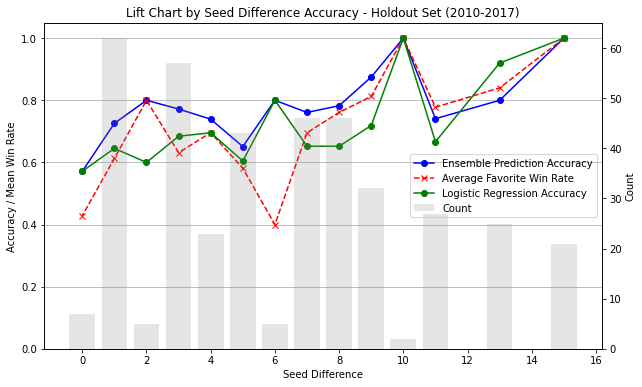

In [1503]:
# Calculate mean win rate by seed difference
mean_win_rate_by_seed_diff = holdout_df.groupby('Seed_Difference')['Win'].mean()
mean_win_rate_by_seed_diff.index = mean_win_rate_by_seed_diff.index.to_series().abs()

# Prepare data for lift chart
lift_data = accuracy_seed_diff.copy()
lift_data['Mean_Win_Rate'] = mean_win_rate_by_seed_diff

lift_data['Accuracy_lr'] = accuracy_seed_diff_lr['Accuracy']

# Create the lift chart
fig, ax1 = plt.subplots(figsize=(10, 6))

lift_data=lift_data.drop(12)

# Plot accuracy
ax1.plot(lift_data.index, lift_data['Accuracy'], marker='o', label='Ensemble Prediction Accuracy', color='blue')
ax1.plot(lift_data.index, lift_data['Mean_Win_Rate'], marker='x', label='Average Favorite Win Rate', color='red', linestyle='--')
ax1.plot(lift_data.index, lift_data['Accuracy_lr'], marker='o', label='Logistic Regression Accuracy', color='green')

ax2 = plt.gca().twinx()  # Create a second y-axis
ax2.bar(lift_data.index, lift_data['Count'], color='gray', alpha=0.2, label='Count')
ax2.set_ylabel('Count')


# Add labels and title
ax1.set_title('Lift Chart by Seed Difference Accuracy - Holdout Set (2010-2017)')
ax1.set_xlabel('Seed Difference')
ax1.set_ylabel('Accuracy / Mean Win Rate')
ax1.set_ylim(0,1.05)

fig.legend(loc='center right', bbox_to_anchor=(1, .5), bbox_transform=ax1.transAxes)  # Create a single legend


ax1.yaxis.grid(True)  # Add horizontal gridlines

plt.show()


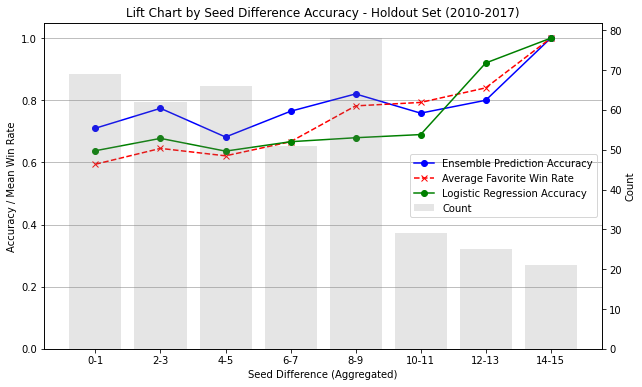

In [1504]:
# Aggregate the data by combining every 2 rows
# Group by seed difference ranges and calculate weighted averages
grouped = lift_data.groupby(lift_data.index // 2)
lift_data_aggregated = pd.DataFrame()
lift_data_aggregated['Accuracy'] = grouped.apply(lambda x: (x['Accuracy'] * x['Count']).sum() / x['Count'].sum())
lift_data_aggregated['Mean_Win_Rate'] = grouped.apply(lambda x: (x['Mean_Win_Rate'] * x['Count']).sum() / x['Count'].sum())
lift_data_aggregated['Accuracy_lr'] = grouped.apply(lambda x: (x['Accuracy_lr'] * x['Count']).sum() / x['Count'].sum())
lift_data_aggregated['Count'] = grouped['Count'].sum()
lift_data_aggregated.index = lift_data_aggregated.index * 2
lift_data_aggregated.index = lift_data_aggregated.index.astype(str) + '-' + (lift_data_aggregated.index + 1).astype(str)


# Create the lift chart for the aggregated data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy for aggregated data
ax1.plot(lift_data_aggregated.index, lift_data_aggregated['Accuracy'], marker='o', label='Ensemble Prediction Accuracy', color='blue')
ax1.plot(lift_data_aggregated.index, lift_data_aggregated['Mean_Win_Rate'], marker='x', label='Average Favorite Win Rate', color='red', linestyle='--')
ax1.plot(lift_data_aggregated.index, lift_data_aggregated['Accuracy_lr'], marker='o', label='Logistic Regression Accuracy', color='green')

ax2 = plt.gca().twinx()  # Create a second y-axis
ax2.bar(lift_data_aggregated.index, lift_data_aggregated['Count'], color='gray', alpha=0.2, label='Count')
ax2.set_ylabel('Count')

# Add labels and title
ax1.set_title('Lift Chart by Seed Difference Accuracy - Holdout Set (2010-2017)')
ax1.set_xlabel('Seed Difference (Aggregated)')
ax1.set_ylabel('Accuracy / Mean Win Rate')
ax1.set_ylim(0, 1.05)

fig.legend(loc='center right', bbox_to_anchor=(1, .5), bbox_transform=ax1.transAxes)  # Create a single legend

ax1.yaxis.grid(True)  # Add horizontal gridlines

plt.show()


In [1505]:
lift_data_aggregated


,Accuracy,Mean_Win_Rate,Accuracy_lr,Count
Seed_Difference,,,,
0-1,0.710145,0.594203,0.637681,69
2-3,0.774194,0.645161,0.677419,62
4-5,0.681818,0.621212,0.636364,66
6-7,0.764706,0.666667,0.666667,51
8-9,0.820513,0.782051,0.679487,78
10-11,0.758621,0.793103,0.689655,29
12-13,0.800000,0.840000,0.920000,25
14-15,1.000000,1.000000,1.000000,21


In [1506]:
lift_data

,Count,Accuracy,Mean_Win_Rate,Accuracy_lr
Seed_Difference,,,,
15,21,1.000000,1.000000,1.000000
13,25,0.800000,0.840000,0.920000
11,27,0.740741,0.777778,0.666667
10,2,1.000000,1.000000,1.000000
9,32,0.875000,0.812500,0.718750
8,46,0.782609,0.760870,0.652174
7,46,0.760870,0.695652,0.652174
6,5,0.800000,0.400000,0.800000
5,43,0.651163,0.581395,0.604651


## 2025 Tournament

In [1507]:
# url = 'https://www.sports-reference.com/cbb/postseason/2025-ncaa.html'

# data_dict={
#     'Season':[],
#     'Round':[],
#     'Team_1':[],
#     'Team_2':[],
#     'Team_1_Seed':[],
#     'Team_2_Seed':[],
# }
# region_list = ['east', 'west', 'midwest', 'south']
# year_list = ['2025']
# for year in year_list:
#     url = f'https://www.sports-reference.com/cbb/postseason/{year}-ncaa.html'
#     options = Options()
#     options.add_argument('--headless')
#     options.add_argument('--disable-gpu')
#     driver = webdriver.Chrome('C:\Program Files\ChromeDriver\chromedriver.exe',options=options)
#     driver.get(url)
#     time.sleep(2)
#     page = driver.page_source
#     soup = bs4.BeautifulSoup(page, 'html.parser')
#     driver.quit()
#     for region in region_list:
#         games = soup.find('div', {'id':'brackets'}).find('div', {'id':region}).find_all('div', {'class':'round'})[0].find_all('div')
#         for i in range(0, len(games), 3):
#             data = games[i].get_text().replace('\n', ' ').split(' at ')[0].split()
#             if 'Play-In' in data:
#                 data_dict['Season'].append(year)
#                 data_dict['Round'].append(1)
#                 team1 = ' '.join([x for x in data[:3] if x.isalpha()])
#                 num_list = [x for x in data if x.isnumeric()]
#                 team_1_seed = int(num_list[0])
#                 data_dict['Team_1'].append(team1)
#                 data_dict['Team_2'].append(region+'_Play-In')

#                 data_dict['Team_1_Seed'].append(team_1_seed)
#                 data_dict['Team_2_Seed'].append(17-team_1_seed)
#             else:
#                 data_dict['Season'].append(year)
#                 data_dict['Round'].append(1)
#                 team1 = ' '.join([x for x in data[:3] if x.isalpha()])
#                 team2 = ' '.join([x for x in data[3:] if x.isalpha()])
#                 num_list = [x for x in data if x.isnumeric()]
#                 team_1_seed = int(num_list[0])
#                 team_2_seed = int(num_list[1])
#                 if team_2_seed < team_1_seed:
#                     temp = team1
#                     temp_seed = team_1_seed
#                     temp_score = team_1_score
#                     team1 = team2
#                     team_1_seed = team_2_seed
#                     team_1_score = team_2_score
#                     team2 = temp
#                     team_2_seed = temp_seed
#                     team_2_score = temp_score

#                 data_dict['Team_1'].append(team1)
#                 data_dict['Team_2'].append(team2)

#                 data_dict['Team_1_Seed'].append(team_1_seed)
#                 data_dict['Team_2_Seed'].append(team_2_seed)

# tourney_25 = pd.DataFrame.from_dict(data_dict)

In [1508]:
# tourney_25 = tourney_25.replace({
#     'east_Play-In':'Indiana',
#     'west_Play-In':'Notre Dame',
#     'south_Play-In':'Wright State',
#     'midwest_Play-In':'Texas Southern',
#     'State Creighton':'Creighton',
# })
# tourney_25.loc[tourney_25['Team_1']=='Kentucky', 'Team_2']='Saint Peter\'s'

# tourney_25

In [1509]:
tourney_25 = pd.read_csv('data/2025_tournament_bracket.csv')

In [1510]:
teams_list = list(tourney_25['Team_1'].str.strip().append(tourney_25['Team_2'].str.strip()))

In [1511]:
teams_list.sort()

In [1512]:
teams_list

['Akron',
 'Alabama',
 'Alabama State',
 'Arizona',
 'Arkansas',
 'Auburn',
 'BYU',
 'Baylor',
 'Bryant',
 'Clemson',
 'Colorado State',
 'Creighton',
 'Drake',
 'Duke',
 'Florida',
 'Georgia',
 'Gonzaga',
 'Grand Canyon',
 'High Point',
 'Houston',
 'Illinois',
 'Iowa State',
 'Kansas',
 'Kentucky',
 'Liberty',
 'Lipscomb',
 'Louisville',
 'Marquette',
 'Maryland',
 'McNeese State',
 'Memphis',
 'Michigan',
 'Michigan State',
 'Mississippi',
 'Mississippi State',
 'Missouri',
 'Montana',
 'Mount',
 'New Mexico',
 'Norfolk State',
 'North Carolina',
 'Oklahoma',
 'Omaha',
 'Oregon',
 'Purdue',
 'Robert Morris',
 'SIU Edwardsville',
 'Saint',
 'Saint Johns',
 'San Diego',
 'Tennessee',
 'Texas',
 'Texas A&M',
 'Texas Tech',
 'Troy',
 'UCLA',
 'UConn',
 'UNC Wilmington',
 'Utah State',
 'VCU',
 'Vanderbilt',
 'Wisconsin',
 'Wofford',
 'Yale']

In [1513]:
basic = pd.read_html(f'https://www.sports-reference.com/cbb/seasons/2025-school-stats.html')[0]
subset = basic['Conf.'].copy()
subset = subset.replace({'W':0,'L':0, 'Conf.':0})
subset = subset.astype('float')
conf_pct = subset['W']/(subset['W']+subset['L'])
basic = basic.droplevel(0, axis=1)
col_list = list(basic.columns[1:8]) + list(basic.columns[-20:-18]) + list(basic.columns[-17:])
basic = basic[col_list].copy()
basic = basic.loc[:,~basic.columns.duplicated()]
basic = basic.dropna()
basic.insert(5,'Conf. Pct', conf_pct)

advanced = pd.read_html(f'https://www.sports-reference.com/cbb/seasons/2025-advanced-school-stats.html')[0]
subset = advanced['School Advanced'].copy()
subset.insert(0,'School', advanced.droplevel(0, axis=1)['School'])
subset['School']=subset['School'].str.strip().str.replace('NCAA', '').str.strip()
basic = basic.loc[basic['School']!='School',:].copy()
basic['School']=basic['School'].str.strip().str.replace('NCAA', '').str.strip()
basic.iloc[:,1:] = basic.iloc[:,1:].astype('float')
for column in basic.columns[4:]:
    if basic[column].mean()>1 and '%' not in column:
        basic[column] = basic[column]/basic['G']

final = basic.merge(subset, on='School')
final = final.loc[final['School']!='School',:].copy()
final.iloc[:,1:] = final.iloc[:,1:].astype('float')

final.insert(0,'Season', '2025')
final['School']=final['School'].str.strip().str.replace('NCAA', '').str.strip()
school_replace_dict = {
    'Southern Methodist':'SMU',
    'Miami (FL)':'Miami',
    'Saint Mary\'s (CA)':'Saint',
    'Maryland-Baltimore County':'UMBC',
    'Loyola (IL)':'Loyola',
    'Virginia Commonwealth':'VCU',
    'Louisiana State': 'LSU',
    'Brigham Young':'BYU',
    'Connecticut': 'UConn',
    'Southern California' :'USC',
    'East Tennessee State':'ETSU',
    'Mount St. Mary\'s':'Mount',
    'St. Bonaventure':'Bonaventure',
    'Stephen F. Austin':'Stephen Austin',
    'Pennsylvania':'Penn',
    'Central Florida':'UCF',
    'UC Santa Barbara':'UCSB',
    'St. John\'s (NY)':'Saint Johns'
    
}

final['School']=final['School'].replace(school_replace_dict)
final = final[final['School'].isin(teams_list)]

final


,Season,School,G,W,L,W-L%,Conf. Pct,SRS,SOS,Tm.,...,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA
2,2025,Akron,34.0,28.0,6.0,0.824,0.944444,3.71,-4.36,84.588235,...,0.461,0.583,53.0,59.2,10.6,9.8,0.557,14.2,33.5,0.195
3,2025,Alabama,33.0,25.0,8.0,0.758,0.722222,26.04,16.35,91.121212,...,0.462,0.594,54.0,54.1,7.9,10.1,0.563,14.3,34.7,0.287
5,2025,Alabama State,35.0,20.0,15.0,0.571,0.666667,-9.27,-9.04,73.342857,...,0.428,0.506,47.9,45.6,11.3,8.1,0.476,11.1,28.9,0.200
10,2025,Arizona,34.0,22.0,12.0,0.647,0.700000,23.13,13.84,81.735294,...,0.346,0.573,54.7,56.7,10.9,12.0,0.529,13.8,35.9,0.287
12,2025,Arkansas,33.0,20.0,13.0,0.606,0.444444,16.67,11.21,76.606061,...,0.367,0.563,50.6,53.2,10.8,15.4,0.527,14.6,27.6,0.261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,2025,Vanderbilt,32.0,20.0,12.0,0.625,0.444444,15.04,10.19,79.625000,...,0.402,0.554,50.3,50.1,12.8,11.4,0.517,12.6,32.2,0.254
340,2025,VCU,34.0,28.0,6.0,0.824,0.833333,14.96,1.14,77.117647,...,0.476,0.560,53.5,56.4,12.1,15.6,0.525,14.1,37.1,0.244
357,2025,Wisconsin,35.0,26.0,9.0,0.743,0.650000,20.94,11.65,79.714286,...,0.481,0.582,51.8,54.9,7.5,6.1,0.536,12.4,28.0,0.279
358,2025,Wofford,34.0,19.0,15.0,0.559,0.555556,-0.26,-3.01,75.323529,...,0.480,0.555,55.5,56.0,9.2,8.7,0.535,13.9,37.0,0.203


In [1514]:
final.loc[final['School'].str.contains('North Carolina'), :]

,Season,School,G,W,L,W-L%,Conf. Pct,SRS,SOS,Tm.,...,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA
206,2025,North Carolina,36.0,23.0,13.0,0.639,0.65,17.79,11.38,81.194444,...,0.371,0.578,52.3,51.2,8.3,9.6,0.545,13.3,29.3,0.26


In [1515]:
final.to_csv('data/2025_season_stats.csv', index=False)

In [1516]:
final = pd.read_csv('data/2025_season_stats.csv')
tourney_25=pd.read_csv('data/2025_tournament_bracket.csv')

tourney_25['Season']=tourney_25['Season'].astype('int')
final['Season']=final['Season'].astype('int')

tourney_25['Team_1']=tourney_25['Team_1'].str.strip()
tourney_25['Team_2']=tourney_25['Team_2'].str.strip()

df_25 = tourney_25.merge(final, left_on=['Season', 'Team_1'], right_on=['Season', 'School'], how='left')
df_25 = df_25.drop(columns='School').rename(columns={col : col+'_1' for col in df_25.columns[6:]})
df_25 = df_25.merge(final, left_on=['Season', 'Team_2'], right_on=['Season', 'School'], how='left')
df_25 = df_25.drop(columns='School').rename(columns={col : col+'_2' for col in df_25.columns[46:]})
df_25

,Season,Team_1,Team_2,Team_1_Seed,Team_2_Seed,G_1,W_1,L_1,W-L%_1,Conf. Pct_1,...,3PAr_2,TS%_2,TRB%_2,AST%_2,STL%_2,BLK%_2,eFG%_2,TOV%_2,ORB%_2,FT/FGA_2
0,2025,Auburn,Alabama State,1,16,33.0,28.0,5.0,0.848,0.833333,...,0.428,0.506,47.9,45.6,11.3,8.1,0.476,11.1,28.9,0.200
1,2025,Louisville,Creighton,8,9,34.0,27.0,7.0,0.794,0.900000,...,0.490,0.583,52.4,63.4,5.4,10.7,0.558,16.0,26.9,0.209
2,2025,Michigan,San Diego,5,12,34.0,25.0,9.0,0.735,0.700000,...,0.357,0.501,47.9,45.9,10.4,10.2,0.459,16.0,30.1,0.230
3,2025,Texas A&M,Yale,4,13,32.0,22.0,10.0,0.688,0.611111,...,0.322,0.581,55.1,54.5,8.4,12.0,0.553,12.4,33.5,0.231
4,2025,Mississippi,North Carolina,6,11,33.0,22.0,11.0,0.667,0.555556,...,0.371,0.578,52.3,51.2,8.3,9.6,0.545,13.3,29.3,0.260
5,2025,Iowa State,Lipscomb,3,14,33.0,24.0,9.0,0.727,0.650000,...,0.472,0.593,51.4,54.7,10.2,8.0,0.558,12.5,25.7,0.243
6,2025,Marquette,New Mexico,7,10,33.0,23.0,10.0,0.697,0.650000,...,0.323,0.546,52.7,52.2,12.0,14.2,0.515,13.3,31.9,0.255
7,2025,Michigan State,Bryant,2,15,33.0,27.0,6.0,0.818,0.850000,...,0.354,0.549,53.4,49.5,9.1,14.5,0.520,13.8,34.9,0.214
8,2025,Florida,Norfolk State,1,16,34.0,30.0,4.0,0.882,0.777778,...,0.288,0.577,51.8,50.3,10.1,9.1,0.537,15.6,32.6,0.293
9,2025,UConn,Oklahoma,8,9,33.0,23.0,10.0,0.697,0.700000,...,0.419,0.595,48.4,52.0,11.2,6.8,0.549,15.4,26.5,0.315


In [1517]:
df_25.to_csv('data/2025_tourney_modeling_df.csv', index=False)

In [1518]:
kenpom_25 = pd.read_html('kenpom/2025 Pomeroy College Basketball Ratings.html')[0]

kenpom_25.columns = kenpom_25.columns.get_level_values(1)

cols_to_keep = [1,4,5,7,9,11]

kenpom_25 = kenpom_25.iloc[:,cols_to_keep]

kenpom_25['Team'] = kenpom_25['Team'].str.replace(r'[^a-zA-Z\s]', '', regex=True).str.strip()
kenpom_25['Team'] = kenpom_25['Team'].str.replace(' St', ' State')
kenpom_25=kenpom_25.reset_index(drop=True)
kenpom_25.columns = ['Team']+[x+'_kenpom' for x in kenpom_25.columns[1:]]

school_replace_dict = {
    'Mount State Marys':'Mount',
    'McNeese':'McNeese State',
    'SIUE':'SIU Edwardsville',
    'Nebraska Omaha':'Omaha',
    'St Johns':'Saint Johns',
    'Connecticut':'UConn',
    'Saint Marys':'Saint',
    'Texas AM':'Texas A&M',
    'UNC':'North Carolina',
}

kenpom_25['Team'] = kenpom_25['Team'].replace(school_replace_dict)

kenpom_25.to_csv('data/kenpom_25.csv', index=False)


In [1519]:
kenpom_25.loc[kenpom_25['Team']=='North Carolina', 'Team']


32    North Carolina
Name: Team, dtype: object

In [1520]:
df_25.loc[df_25['Team_2']=='North Carolina', :]


,Season,Team_1,Team_2,Team_1_Seed,Team_2_Seed,G_1,W_1,L_1,W-L%_1,Conf. Pct_1,...,3PAr_2,TS%_2,TRB%_2,AST%_2,STL%_2,BLK%_2,eFG%_2,TOV%_2,ORB%_2,FT/FGA_2
4,2025,Mississippi,North Carolina,6,11,33.0,22.0,11.0,0.667,0.555556,...,0.371,0.578,52.3,51.2,8.3,9.6,0.545,13.3,29.3,0.26


In [1521]:
kenpom_25

,Team,NetRtg_kenpom,ORtg_kenpom,DRtg_kenpom,AdjT_kenpom,Luck_kenpom
0,Duke,38.16,128.0,89.8,65.7,-0.019
1,Florida,36.16,128.6,92.4,69.6,0.007
2,Houston,35.44,123.2,87.8,61.4,0.015
3,Auburn,35.05,128.4,93.4,67.6,0.030
4,Tennessee,31.15,120.3,89.1,63.6,0.016
...,...,...,...,...,...,...
359,Alabama AM,-23.50,92.0,115.5,71.0,-0.022
360,Coppin State,-24.29,87.3,111.6,67.7,0.033
361,Chicago State,-24.31,91.8,116.2,68.2,-0.024
362,Arkansas Pine Bluff,-26.08,95.0,121.1,71.3,-0.074


In [1522]:
df_25 = pd.read_csv('data/2025_tourney_modeling_df.csv')
kenpom=pd.read_csv('data/kenpom_25.csv')

kenpom.insert(0, 'Season', 2025)

df_25=df_25.merge(kenpom, left_on=['Season', 'Team_1'], right_on=['Season', 'Team'], how='left')
df_25=df_25.rename(columns={col : col+'_1' for col in df_25.columns if 'kenpom' in col})

df_25=df_25.merge(kenpom, left_on=['Season', 'Team_2'], right_on=['Season', 'Team'], how='left')
df_25=df_25.rename(columns={col : col+'_2' for col in df_25.columns if ('kenpom' in col and '_1' not in col)})

df_25=df_25.drop(columns=['Team_x', 'Team_y'])

df_25




,Season,Team_1,Team_2,Team_1_Seed,Team_2_Seed,G_1,W_1,L_1,W-L%_1,Conf. Pct_1,...,NetRtg_kenpom_1,ORtg_kenpom_1,DRtg_kenpom_1,AdjT_kenpom_1,Luck_kenpom_1,NetRtg_kenpom_2,ORtg_kenpom_2,DRtg_kenpom_2,AdjT_kenpom_2,Luck_kenpom_2
0,2025,Auburn,Alabama State,1,16,33.0,28.0,5.0,0.848,0.833333,...,35.05,128.4,93.4,67.6,0.030,-9.24,101.4,110.6,67.7,0.049
1,2025,Louisville,Creighton,8,9,34.0,27.0,7.0,0.794,0.900000,...,22.64,118.1,95.5,68.7,0.058,18.70,116.9,98.2,67.0,0.049
2,2025,Michigan,San Diego,5,12,34.0,25.0,9.0,0.735,0.700000,...,22.28,116.0,93.7,69.4,0.070,-11.26,99.4,110.6,71.0,-0.074
3,2025,Texas A&M,Yale,4,13,32.0,22.0,10.0,0.688,0.611111,...,24.08,116.2,92.1,66.1,0.001,11.05,115.1,104.0,67.2,-0.041
4,2025,Mississippi,North Carolina,6,11,33.0,22.0,11.0,0.667,0.555556,...,22.09,117.8,95.8,68.0,0.018,19.55,118.9,99.3,70.4,-0.019
5,2025,Iowa State,Lipscomb,3,14,33.0,24.0,9.0,0.727,0.650000,...,26.99,119.4,92.4,68.6,-0.048,9.49,112.7,103.2,65.9,-0.028
6,2025,Marquette,New Mexico,7,10,33.0,23.0,10.0,0.697,0.650000,...,21.58,117.7,96.1,67.6,-0.013,17.32,112.5,95.2,72.7,-0.000
7,2025,Michigan State,Bryant,2,15,33.0,27.0,6.0,0.818,0.850000,...,27.57,118.1,90.6,67.7,-0.009,1.18,106.7,105.5,72.4,-0.003
8,2025,Florida,Norfolk State,1,16,34.0,30.0,4.0,0.882,0.777778,...,36.16,128.6,92.4,69.6,0.007,-1.53,107.1,108.7,66.3,0.056
9,2025,UConn,Oklahoma,8,9,33.0,23.0,10.0,0.697,0.700000,...,19.34,121.9,102.6,63.7,-0.019,18.36,119.0,100.7,68.5,0.005


In [1523]:
df_25['Seed_Diff'] = df_25['Team_1_Seed'] - df_25['Team_2_Seed']
df_25['four_factors_1'] = df_25['eFG%_1'] + df_25['TOV_1'] - df_25['ORB_1'] + df_25['FT_1']
df_25['net_net_rtg'] = df_25['NetRtg_kenpom_1'] - df_25['NetRtg_kenpom_2']
df_25['net_off_rtg'] = df_25['ORtg_kenpom_1'] - df_25['ORtg_kenpom_2']

# Create a dataframe to store rolling tournament wins
rolling_position_wins_df = pd.DataFrame(index=df_25.index)

# Initialize columns for rolling wins
rolling_position_wins_df['Rolling_3yr_Team1_Wins_1'] = 0
rolling_position_wins_df['Rolling_3yr_Team2_Wins_1'] = 0
rolling_position_wins_df['Rolling_3yr_Team1_Wins_diff'] = 0
rolling_position_wins_df['Rolling_3yr_Team2_Wins_diff'] = 0

# Get unique teams from df_25
teams = pd.concat([df_25['Team_1'], df_25['Team_2']]).unique()

# Filter for recent years (2022-2024)
previous_seasons = [2022, 2023, 2024]

# Process Team_1 wins (when Team_1 wins)
team1_as_team1_wins = modeling_df[modeling_df['Win'] == True][['Season', 'Team_1']]
team1_as_team1_wins = team1_as_team1_wins.rename(columns={'Team_1': 'Team'})
team1_as_team1_wins['Wins_as_Team1'] = 1
team1_as_team1_wins = team1_as_team1_wins.groupby(['Team', 'Season']).sum().reset_index()

# Process Team_2 wins (when Team_1 loses)
team2_as_team2_wins = modeling_df[modeling_df['Win'] == False][['Season', 'Team_2']]
team2_as_team2_wins = team2_as_team2_wins.rename(columns={'Team_2': 'Team'})
team2_as_team2_wins['Wins_as_Team2'] = 1
team2_as_team2_wins = team2_as_team2_wins.groupby(['Team', 'Season']).sum().reset_index()

# Create functions to calculate rolling 3-year tournament wins as Team_1 and Team_2
def calculate_rolling_team1_wins(team, seasons):
    wins = team1_as_team1_wins[(team1_as_team1_wins['Team'] == team) & 
                              (team1_as_team1_wins['Season'].isin(seasons))]['Wins_as_Team1'].sum()
    return wins

def calculate_rolling_team2_wins(team, seasons):
    wins = team2_as_team2_wins[(team2_as_team2_wins['Team'] == team) & 
                              (team2_as_team2_wins['Season'].isin(seasons))]['Wins_as_Team2'].sum()
    return wins

# Apply the functions to create rolling tournament win features by team position
for idx in df_25.index:
    team1 = df_25.loc[idx, 'Team_1']
    team2 = df_25.loc[idx, 'Team_2']
    
    # Calculate rolling wins for Team_1
    team1_rolling_team1_wins = calculate_rolling_team1_wins(team1, previous_seasons)
    team1_rolling_team2_wins = calculate_rolling_team2_wins(team1, previous_seasons)
    team1_total_wins = team1_rolling_team1_wins + team1_rolling_team2_wins
    
    # Calculate rolling wins for Team_2
    team2_rolling_team1_wins = calculate_rolling_team1_wins(team2, previous_seasons)
    team2_rolling_team2_wins = calculate_rolling_team2_wins(team2, previous_seasons)
    team2_total_wins = team2_rolling_team1_wins + team2_rolling_team2_wins
    
    # Store values in rolling_position_wins_df
    rolling_position_wins_df.at[idx, 'Rolling_3yr_Team1_Wins_1'] = team1_rolling_team1_wins
    rolling_position_wins_df.at[idx, 'Rolling_3yr_Team2_Wins_1'] = team1_rolling_team2_wins
    rolling_position_wins_df.at[idx, 'Rolling_3yr_Tournament_Wins_1'] = team1_total_wins
    rolling_position_wins_df.at[idx, 'Rolling_3yr_Tournament_Wins_2'] = team2_total_wins
    rolling_position_wins_df.at[idx, 'Rolling_3yr_Tournament_Wins_diff'] = team1_total_wins - team2_total_wins
    
    # Add scaled features to df_25
    df_25['Rolling_3yr_Tournament_Wins_1'] = rolling_position_wins_df['Rolling_3yr_Tournament_Wins_1']
    df_25['Rolling_3yr_Tournament_Wins_diff'] = rolling_position_wins_df['Rolling_3yr_Tournament_Wins_diff']
    df_25['Rolling_3yr_Team2_Wins_1'] = rolling_position_wins_df['Rolling_3yr_Team2_Wins_1']


In [1524]:
rolling_position_wins_df.columns

Index(['Rolling_3yr_Team1_Wins_1', 'Rolling_3yr_Team2_Wins_1',
       'Rolling_3yr_Team1_Wins_diff', 'Rolling_3yr_Team2_Wins_diff',
       'Rolling_3yr_Tournament_Wins_1', 'Rolling_3yr_Tournament_Wins_2',
       'Rolling_3yr_Tournament_Wins_diff'],
      dtype='object')

In [1525]:
rolling_position_wins_df

,Rolling_3yr_Team1_Wins_1,Rolling_3yr_Team2_Wins_1,Rolling_3yr_Team1_Wins_diff,Rolling_3yr_Team2_Wins_diff,Rolling_3yr_Tournament_Wins_1,Rolling_3yr_Tournament_Wins_2,Rolling_3yr_Tournament_Wins_diff
0,1,1,0,0,2.0,0.0,2.0
1,0,0,0,0,0.0,5.0,-5.0
2,0,2,0,0,2.0,0.0,2.0
3,0,0,0,0,0.0,1.0,-1.0
4,0,0,0,0,0.0,0.0,0.0
5,2,2,0,0,4.0,0.0,4.0
6,3,0,0,0,3.0,0.0,3.0
7,2,2,0,0,4.0,0.0,4.0
8,0,0,0,0,0.0,0.0,0.0
9,10,1,0,0,11.0,0.0,11.0


In [1526]:
df_25[features]

,W-L%_1,3P_1,TRB_1,AST%_1,Conf. Pct_2,FT%_2,ORB_2,TRB_2,TRB%_2,ORtg_kenpom_1,Luck_kenpom_1,Luck_kenpom_2,Seed_Diff,four_factors_1,net_net_rtg,net_off_rtg,Rolling_3yr_Tournament_Wins_1,Rolling_3yr_Tournament_Wins_diff,Rolling_3yr_Team2_Wins_1
0,0.848,9.181818,37.060606,55.5,0.666667,0.689,11.685714,36.200000,47.9,128.4,0.030,0.049,-15,13.405485,44.29,27.0,2.0,2.0,1
1,0.794,9.411765,37.441176,51.9,0.750000,0.733,8.617647,37.705882,52.4,118.1,0.058,0.049,-1,16.034000,3.94,1.2,0.0,-5.0,0
2,0.735,8.264706,38.176471,58.5,0.111111,0.752,11.545455,34.303030,47.9,116.0,0.070,-0.074,-7,18.603824,33.54,16.6,2.0,2.0,2
3,0.688,7.000000,41.218750,47.7,0.928571,0.732,11.137931,38.689655,55.1,116.2,0.001,-0.041,-9,14.006250,13.03,1.1,0.0,-1.0,0
4,0.667,8.242424,33.060606,53.5,0.650000,0.742,9.805556,36.750000,52.3,117.8,0.018,-0.019,-5,15.995848,2.54,-1.1,0.0,0.0,0
5,0.727,7.666667,35.424242,53.9,0.777778,0.794,8.294118,35.823529,51.4,119.4,-0.048,-0.028,-11,19.061152,17.50,6.7,4.0,4.0,2
6,0.697,9.393939,34.212121,49.5,0.850000,0.687,12.242424,39.303030,52.7,117.7,-0.013,-0.000,-3,10.610909,4.26,5.2,3.0,3.0,0
7,0.818,5.969697,39.818182,61.6,0.875000,0.717,13.411765,41.470588,53.4,118.1,-0.009,-0.003,-13,17.754424,26.39,11.4,4.0,4.0,2
8,0.882,9.911765,42.029412,52.4,0.785714,0.756,10.117647,34.705882,51.8,128.6,0.007,0.056,-15,12.344118,37.69,21.5,0.0,0.0,0
9,0.697,8.636364,35.606061,64.0,0.333333,0.794,8.333333,32.060606,48.4,121.9,-0.019,0.005,-1,14.555000,0.98,2.9,11.0,11.0,1


In [1527]:
df_25

,Season,Team_1,Team_2,Team_1_Seed,Team_2_Seed,G_1,W_1,L_1,W-L%_1,Conf. Pct_1,...,DRtg_kenpom_2,AdjT_kenpom_2,Luck_kenpom_2,Seed_Diff,four_factors_1,net_net_rtg,net_off_rtg,Rolling_3yr_Tournament_Wins_1,Rolling_3yr_Tournament_Wins_diff,Rolling_3yr_Team2_Wins_1
0,2025,Auburn,Alabama State,1,16,33.0,28.0,5.0,0.848,0.833333,...,110.6,67.7,0.049,-15,13.405485,44.29,27.0,2.0,2.0,1
1,2025,Louisville,Creighton,8,9,34.0,27.0,7.0,0.794,0.900000,...,98.2,67.0,0.049,-1,16.034000,3.94,1.2,0.0,-5.0,0
2,2025,Michigan,San Diego,5,12,34.0,25.0,9.0,0.735,0.700000,...,110.6,71.0,-0.074,-7,18.603824,33.54,16.6,2.0,2.0,2
3,2025,Texas A&M,Yale,4,13,32.0,22.0,10.0,0.688,0.611111,...,104.0,67.2,-0.041,-9,14.006250,13.03,1.1,0.0,-1.0,0
4,2025,Mississippi,North Carolina,6,11,33.0,22.0,11.0,0.667,0.555556,...,99.3,70.4,-0.019,-5,15.995848,2.54,-1.1,0.0,0.0,0
5,2025,Iowa State,Lipscomb,3,14,33.0,24.0,9.0,0.727,0.650000,...,103.2,65.9,-0.028,-11,19.061152,17.50,6.7,4.0,4.0,2
6,2025,Marquette,New Mexico,7,10,33.0,23.0,10.0,0.697,0.650000,...,95.2,72.7,-0.000,-3,10.610909,4.26,5.2,3.0,3.0,0
7,2025,Michigan State,Bryant,2,15,33.0,27.0,6.0,0.818,0.850000,...,105.5,72.4,-0.003,-13,17.754424,26.39,11.4,4.0,4.0,2
8,2025,Florida,Norfolk State,1,16,34.0,30.0,4.0,0.882,0.777778,...,108.7,66.3,0.056,-15,12.344118,37.69,21.5,0.0,0.0,0
9,2025,UConn,Oklahoma,8,9,33.0,23.0,10.0,0.697,0.700000,...,100.7,68.5,0.005,-1,14.555000,0.98,2.9,11.0,11.0,1


In [1528]:
scaler.feature_names_in_

array(['W-L%_1', '3P_1', 'TRB_1', 'AST%_1', 'Conf. Pct_2', 'FT%_2',
       'ORB_2', 'TRB_2', 'TRB%_2', 'ORtg_kenpom_1', 'Luck_kenpom_1',
       'Luck_kenpom_2', 'Seed_Diff', 'four_factors_1', 'net_net_rtg',
       'net_off_rtg', 'Rolling_3yr_Tournament_Wins_1',
       'Rolling_3yr_Tournament_Wins_diff', 'Rolling_3yr_Team2_Wins_1'],
      dtype=object)

In [1529]:
total_df['G_1']

0      38.0
1      34.0
2      35.0
3      33.0
4      34.0
       ... 
759    37.0
760    36.0
761    40.0
762    39.0
763    40.0
Name: G_1, Length: 764, dtype: float64

In [1530]:
# with open ('std_scaler.bin', 'rb') as file:
#     scaler = load(file)
scaler = scaler_dict[1]
df_25[features]=scaler.transform(df_25[features])
df_25.insert(6, 'Proba', voting_clf.predict_proba(df_25[features])[:,1])
df_25.insert(6, 'Pred', voting_clf.predict_proba(df_25[features])[:,1]>voting_thresh)
df_25[features]=scaler.inverse_transform(df_25[features])
df_25

,Season,Team_1,Team_2,Team_1_Seed,Team_2_Seed,G_1,Pred,Proba,W_1,L_1,...,DRtg_kenpom_2,AdjT_kenpom_2,Luck_kenpom_2,Seed_Diff,four_factors_1,net_net_rtg,net_off_rtg,Rolling_3yr_Tournament_Wins_1,Rolling_3yr_Tournament_Wins_diff,Rolling_3yr_Team2_Wins_1
0,2025,Auburn,Alabama State,1,16,33.0,True,0.935564,28.0,5.0,...,110.6,67.7,0.049,-15.0,13.405485,44.29,27.0,2.0,2.0,1.0
1,2025,Louisville,Creighton,8,9,34.0,True,0.838697,27.0,7.0,...,98.2,67.0,0.049,-1.0,16.034000,3.94,1.2,0.0,-5.0,0.0
2,2025,Michigan,San Diego,5,12,34.0,True,0.939162,25.0,9.0,...,110.6,71.0,-0.074,-7.0,18.603824,33.54,16.6,2.0,2.0,2.0
3,2025,Texas A&M,Yale,4,13,32.0,True,0.912643,22.0,10.0,...,104.0,67.2,-0.041,-9.0,14.006250,13.03,1.1,0.0,-1.0,0.0
4,2025,Mississippi,North Carolina,6,11,33.0,True,0.638335,22.0,11.0,...,99.3,70.4,-0.019,-5.0,15.995848,2.54,-1.1,0.0,0.0,0.0
5,2025,Iowa State,Lipscomb,3,14,33.0,True,0.863587,24.0,9.0,...,103.2,65.9,-0.028,-11.0,19.061152,17.50,6.7,4.0,4.0,2.0
6,2025,Marquette,New Mexico,7,10,33.0,True,0.820282,23.0,10.0,...,95.2,72.7,0.000,-3.0,10.610909,4.26,5.2,3.0,3.0,0.0
7,2025,Michigan State,Bryant,2,15,33.0,True,0.930288,27.0,6.0,...,105.5,72.4,-0.003,-13.0,17.754424,26.39,11.4,4.0,4.0,2.0
8,2025,Florida,Norfolk State,1,16,34.0,True,0.936891,30.0,4.0,...,108.7,66.3,0.056,-15.0,12.344118,37.69,21.5,0.0,0.0,0.0
9,2025,UConn,Oklahoma,8,9,33.0,False,0.180161,23.0,10.0,...,100.7,68.5,0.005,-1.0,14.555000,0.98,2.9,11.0,11.0,1.0


## Continue Tournament

In [1531]:
temp1 = df_25[[x for x in df_25.columns if '_1' in x]]
temp1.columns = [x.strip('_1') for x in temp1.columns]
temp1 = temp1.drop(columns = 'Team_1_Seed')
temp2 = df_25[[x for x in df_25.columns if '_2' in x]]
temp2.columns = [x.strip('_2') for x in temp2.columns]
temp2 = temp2.drop(columns = 'Team_2_Seed')

stats = temp1.append(temp2)
stats['Season']='2025'
stats = stats.rename(columns={'Team':'School'})

In [1532]:
next_round = pd.DataFrame(df_25.loc[df_25['Pred']==True,['Team_1', 'Team_1_Seed']].rename(columns={'Team_1':'Team', 'Team_1_Seed':'Seed'}).append(df_25.loc[df_25['Pred']==False,['Team_2', 'Team_2_Seed']].rename(columns={'Team_2':'Team', 'Team_2_Seed':'Seed'})))
next_round = next_round.sort_index()

df_list = []

for round in range(2,7):
    data_dict={
        'Season':[],
        'Round':[],
        'Team_1':[],
        'Team_2':[],
        'Team_1_Seed':[],
        'Team_2_Seed':[],
    }
    if round > 2:
        next_round = pd.DataFrame(next_round.loc[next_round['Pred']==True,['Team_1', 'Team_1_Seed']].rename(columns={'Team_1':'Team', 'Team_1_Seed':'Seed'}).append(next_round.loc[next_round['Pred']==False,['Team_2', 'Team_2_Seed']].rename(columns={'Team_2':'Team', 'Team_2_Seed':'Seed'})))
        next_round = next_round.sort_index()
    for i in range(0,len(next_round),2):
        data_dict['Season'].append('2025')
        data_dict['Round'].append(round)
        if next_round.iloc[i,1]<next_round.iloc[i+1,1]:
            team1 = next_round.iloc[i,0]
            team2 = next_round.iloc[i+1,0]
            team1_seed = next_round.iloc[i,1]
            team2_seed = next_round.iloc[i+1,1]
        else:
            team1 = next_round.iloc[i+1,0]
            team2 = next_round.iloc[i,0]
            team1_seed = next_round.iloc[i+1,1]
            team2_seed = next_round.iloc[i,1]
        data_dict['Team_1'].append(team1)
        data_dict['Team_2'].append(team2)
        data_dict['Team_1_Seed'].append(team1_seed)
        data_dict['Team_2_Seed'].append(team2_seed)

    next_round=pd.DataFrame.from_dict(data_dict)

    next_round = next_round.merge(stats, left_on=['Season', 'Team_1'], right_on=['Season', 'School'], how='left')
    next_round = next_round.drop(columns='School').rename(columns={col : col+'_1' for col in next_round.columns[6:]})
    next_round = next_round.merge(stats, left_on=['Season', 'Team_2'], right_on=['Season', 'School'], how='left')
    next_round = next_round.drop(columns='School').rename(columns={col : col+'_2' for col in next_round.columns[53:]})

    next_round['Seed_Diff'] = next_round['Team_1_Seed'] - next_round['Team_2_Seed']
    next_round['net_net_rtg'] = next_round['NetRtg_kenpom_1'] - next_round['NetRtg_kenpom_2']
    next_round['net_off_rtg'] = next_round['ORtg_kenpom_1'] - next_round['ORtg_kenpom_2']
    next_round['Rolling_3yr_Tournament_Wins_diff'] = next_round['Rolling_3yr_Tournament_Wins_1'] - next_round['Rolling_3yr_Tournament_Wins_2']

    scaler=scaler_dict[round]

    next_round[features]=scaler.transform(next_round[features])
    next_round.insert(6, 'Proba', XGB.predict_proba(next_round[features])[:,1])
    next_round.insert(6, 'Pred', XGB.predict_proba(next_round[features])[:,1]>voting_thresh)
    next_round[features]=scaler.inverse_transform(next_round[features])

    df_list.append(next_round.copy())

final = pd.concat([df_25]+df_list)


Glyph 127942 missing from current font.
Glyph 127942 missing from current font.


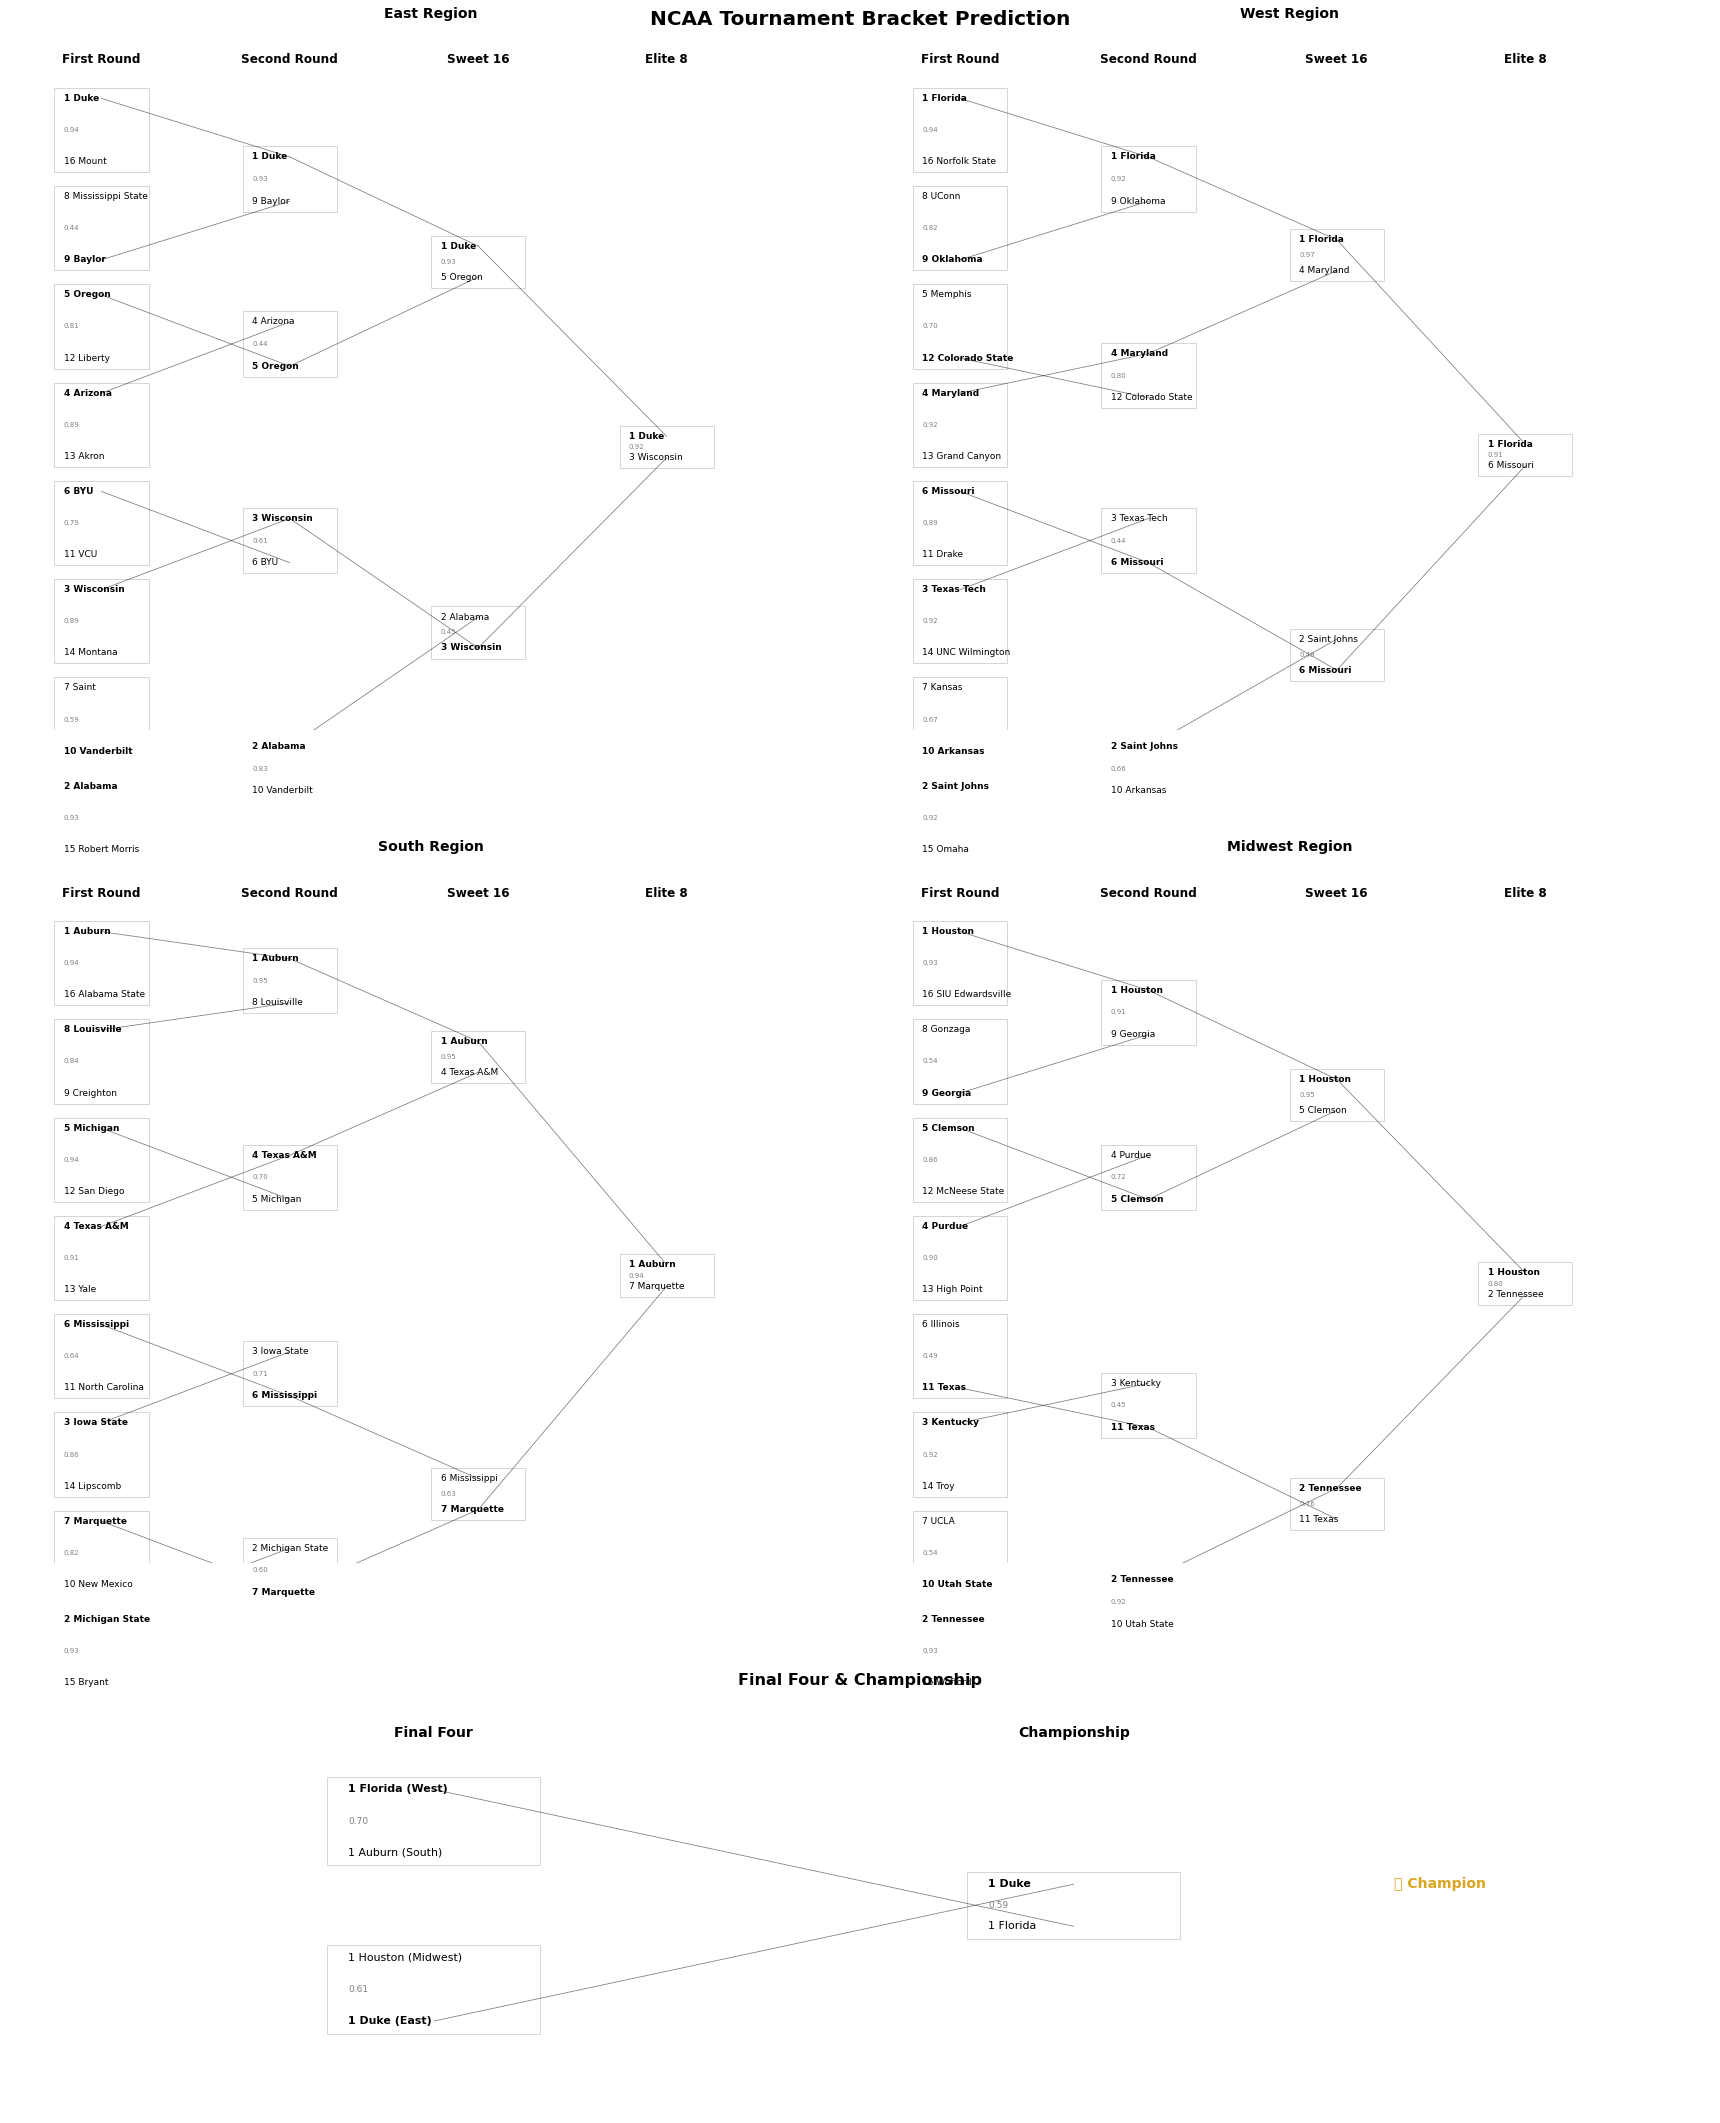

In [1533]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

# Ensure final DataFrame has the required columns
final = final[['Round', 'Team_1', 'Team_2', 'Team_1_Seed', 'Team_2_Seed', 'Pred', 'Proba']].fillna(1)

# Define region names with their Elite 8 winners
region_info = {
    'East': 'Duke',
    'West': 'Florida',
    'South': 'Auburn',
    'Midwest': 'Houston'
}

# Function to draw a regional bracket
def draw_regional_bracket(data, region_name, region_winner, ax):
    # Set background color to white
    ax.set_facecolor('white')
    
    # Filter data for this region (based on the region's winner)
    # First, find the Elite 8 game with this winner
    elite_8_games = data[data['Round'] == 4]
    region_game = None
    
    for _, game in elite_8_games.iterrows():
        if game['Team_1'] == region_winner or game['Team_2'] == region_winner:
            region_game = game
            break
    
    if region_game is None:
        ax.text(4, 10, f"No data found for {region_name} Region", 
                ha='center', fontsize=14, color='red')
        return ax
    
    # Now find all games that involve teams in this region's path
    region_teams = set([region_game['Team_1'], region_game['Team_2']])
    region_data = []
    
    # Work backwards to find all games in this region
    for round_num in range(3, 0, -1):
        round_games = data[data['Round'] == round_num]
        new_teams = set()
        
        for _, game in round_games.iterrows():
            if game['Team_1'] in region_teams or game['Team_2'] in region_teams:
                region_data.append(game)
                new_teams.add(game['Team_1'])
                new_teams.add(game['Team_2'])
        
        region_teams.update(new_teams)
    
    # Add the Elite 8 game itself
    region_data.append(region_game)
    
    # Convert to DataFrame
    region_df = pd.DataFrame(region_data)
    
    # Define round names and positions
    round_names = {1: 'First Round', 2: 'Second Round', 3: 'Sweet 16', 4: 'Elite 8'}
    round_positions = {1: 1, 2: 3, 3: 5, 4: 7}
    
    # Configure axis
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 20)
    ax.axis('off')
    
    # Draw round labels at the top
    for round_num, round_name in round_names.items():
        ax.text(round_positions[round_num], 19, round_name, ha='center', fontsize=12, fontweight='bold')
    
    # Title for the region
    ax.set_title(f"{region_name} Region", fontsize=14, fontweight='bold', pad=10)
    
    # Store team positions
    team_positions = {}
    connecting_lines = []
    
    # First round games
    first_round_games = region_df[region_df['Round'] == 1].copy()
    spacing = 1.8  # Space between teams in a matchup
    game_spacing = 1.0  # Space between different matchups
    
    # Assign positions for first round games
    start_y = 18
    for i, (_, game) in enumerate(first_round_games.iterrows()):
        team1, team2 = game['Team_1'], game['Team_2']
        
        # Calculate position
        y_pos = start_y - i * (spacing + game_spacing)
        
        # Store team positions
        team_positions[(team1, 1)] = (round_positions[1], y_pos)
        team_positions[(team2, 1)] = (round_positions[1], y_pos - spacing)
    
    # Calculate positions for subsequent rounds
    for round_num in range(2, 5):
        round_games = region_df[region_df['Round'] == round_num]
        
        for _, game in round_games.iterrows():
            team1, team2 = game['Team_1'], game['Team_2']
            
            # Find positions of these teams in previous round
            team1_prev = None
            team2_prev = None
            
            for (t, r), pos in team_positions.items():
                if r == round_num - 1:
                    if t == team1:
                        team1_prev = pos
                    elif t == team2:
                        team2_prev = pos
            
            # Calculate new position (midpoint of previous positions)
            if team1_prev and team2_prev:
                y1 = team1_prev[1]
                y2 = team2_prev[1]
                mid_y = (y1 + y2) / 2
                
                # Round-specific spacing (decreases in later rounds)
                round_spacing = spacing * (0.7 ** (round_num - 1))
                
                # Store new positions
                team_positions[(team1, round_num)] = (round_positions[round_num], mid_y + round_spacing/2)
                team_positions[(team2, round_num)] = (round_positions[round_num], mid_y - round_spacing/2)
                
                # Store connecting lines
                connecting_lines.append((team1_prev[0], team1_prev[1], 
                                        round_positions[round_num], mid_y + round_spacing/2))
                connecting_lines.append((team2_prev[0], team2_prev[1], 
                                        round_positions[round_num], mid_y - round_spacing/2))
    
    # Draw all the games
    for round_num in range(1, 5):
        round_games = region_df[region_df['Round'] == round_num]
        
        for _, game in round_games.iterrows():
            team1, team2 = game['Team_1'], game['Team_2']
            seed1, seed2 = int(game['Team_1_Seed']), int(game['Team_2_Seed'])
            
            # Get positions
            pos1 = team_positions.get((team1, round_num))
            pos2 = team_positions.get((team2, round_num))
            
            if pos1 and pos2:
                x1, y1 = pos1
                x2, y2 = pos2
                
                # Determine winner
                winner = team1 if game['Pred'] == 1 else team2
                
                # Format team labels with seeds
                team1_label = f"{seed1} {team1}"
                team2_label = f"{seed2} {team2}"
                
                # Draw team names
                ax.text(x1 - 0.4, y1, team1_label, ha='left', va='center', 
                        fontsize=9, fontweight='bold' if winner == team1 else 'normal')
                ax.text(x2 - 0.4, y2, team2_label, ha='left', va='center',
                        fontsize=9, fontweight='bold' if winner == team2 else 'normal')
                
                # Draw win probability
                prob = game['Proba'] if game['Pred'] == 1 else (1 - game['Proba'])
                prob_text = f"{prob:.2f}"
                mid_y = (y1 + y2) / 2
                ax.text(x1 - 0.4, mid_y, prob_text, ha='left', va='center', fontsize=7, color='gray')
                
                # Draw box around matchup
                box_height = abs(y1 - y2) + 0.6
                box_y = min(y1, y2) - 0.3
                rect = plt.Rectangle((x1 - 0.5, box_y), 1.0, box_height, 
                                    fill=False, alpha=0.4, linewidth=0.8, edgecolor='gray')
                ax.add_patch(rect)
    
    # Draw all connecting lines
    for x1, y1, x2, y2 in connecting_lines:
        # Create curved connecting lines
        curve_x = np.linspace(x1, x2, 50)
        t = (curve_x - x1) / (x2 - x1)
        curve_y = (1-t)**2 * y1 + 2*(1-t)*t*((y1+y2)/2) + t**2 * y2
        ax.plot(curve_x, curve_y, 'k-', alpha=0.5, linewidth=0.8)
    
    return ax

# Function to draw Final Four and Championship
def draw_final_four(data, region_info, ax):
    # Set background color to white
    ax.set_facecolor('white')
    
    # Filter to only the Final Four and Championship rounds
    final_four_data = data[data['Round'] >= 5].copy()
    
    # Define round names and positions
    round_names = {5: 'Final Four', 6: 'Championship'}
    round_positions = {5: 2, 6: 5}
    
    # Configure axis
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Draw round labels at the top
    for round_num, round_name in round_names.items():
        ax.text(round_positions[round_num], 9, round_name, ha='center', fontsize=14, fontweight='bold')
    
    # Title
    ax.set_title("Final Four & Championship", fontsize=16, fontweight='bold', pad=10)
    
    # Store team positions
    team_positions = {}
    connecting_lines = []
    
    # Positions for Final Four (round 5)
    final_four_games = final_four_data[final_four_data['Round'] == 5]
    spacing = 1.5
    y_positions = [7, 3]  # Two positions for two games
    
    # Map regions to teams
    region_to_team = {}
    for region, team in region_info.items():
        region_to_team[region] = team
    
    for i, (_, game) in enumerate(final_four_games.iterrows()):
        team1, team2 = game['Team_1'], game['Team_2']
        team1_seed, team2_seed = int(game['Team_1_Seed']), int(game['Team_2_Seed'])
        
        # Determine regions for these teams
        team1_region = next((region for region, team in region_info.items() if team == team1), "Unknown")
        team2_region = next((region for region, team in region_info.items() if team == team2), "Unknown")
        
        # Store positions
        y_pos = y_positions[i]
        team_positions[(team1, 5)] = (round_positions[5], y_pos + spacing/2)
        team_positions[(team2, 5)] = (round_positions[5], y_pos - spacing/2)
    
    # Position for Championship (round 6)
    championship = final_four_data[final_four_data['Round'] == 6].iloc[0]
    team1, team2 = championship['Team_1'], championship['Team_2']
    
    # Find positions of these teams in Final Four
    team1_prev = team_positions.get((team1, 5))
    team2_prev = team_positions.get((team2, 5))
    
    if team1_prev and team2_prev:
        # Store championship positions
        team_positions[(team1, 6)] = (round_positions[6], 5.5)
        team_positions[(team2, 6)] = (round_positions[6], 4.5)
        
        # Store connecting lines
        connecting_lines.append((team1_prev[0], team1_prev[1], round_positions[6], 5.5))
        connecting_lines.append((team2_prev[0], team2_prev[1], round_positions[6], 4.5))
    
    # Draw all the games
    for round_num in [5, 6]:
        round_games = final_four_data[final_four_data['Round'] == round_num]
        
        for _, game in round_games.iterrows():
            team1, team2 = game['Team_1'], game['Team_2']
            seed1, seed2 = int(game['Team_1_Seed']), int(game['Team_2_Seed'])
            
            # Get positions
            pos1 = team_positions.get((team1, round_num))
            pos2 = team_positions.get((team2, round_num))
            
            if pos1 and pos2:
                x1, y1 = pos1
                x2, y2 = pos2
                
                # Determine winner
                winner = team1 if game['Pred'] == 1 else team2
                
                # Format team labels with seeds and region for Final Four
                if round_num == 5:
                    team1_region = next((region for region, team in region_info.items() if team == team1), "Unknown")
                    team2_region = next((region for region, team in region_info.items() if team == team2), "Unknown")
                    team1_label = f"{seed1} {team1} ({team1_region})"
                    team2_label = f"{seed2} {team2} ({team2_region})"
                else:
                    team1_label = f"{seed1} {team1}"
                    team2_label = f"{seed2} {team2}"
                
                # Draw team names
                ax.text(x1 - 0.4, y1, team1_label, ha='left', va='center', 
                        fontsize=11, fontweight='bold' if winner == team1 else 'normal')
                ax.text(x2 - 0.4, y2, team2_label, ha='left', va='center',
                        fontsize=11, fontweight='bold' if winner == team2 else 'normal')
                
                # Draw win probability
                prob = game['Proba'] if game['Pred'] == 1 else (1 - game['Proba'])
                prob_text = f"{prob:.2f}"
                mid_y = (y1 + y2) / 2
                ax.text(x1 - 0.4, mid_y, prob_text, ha='left', va='center', fontsize=9, color='gray')
                
                # Draw box around matchup
                box_height = abs(y1 - y2) + 0.6
                box_y = min(y1, y2) - 0.3
                rect = plt.Rectangle((x1 - 0.5, box_y), 1.0, box_height, 
                                    fill=False, alpha=0.4, linewidth=0.8, edgecolor='gray')
                ax.add_patch(rect)
                
                # For championship, draw a trophy icon or highlight
                if round_num == 6:
                    winner_y = y1 if winner == team1 else y2
                    ax.text(x1 + 1.5, winner_y, "🏆 Champion", fontsize=14, 
                           ha='left', va='center', color='goldenrod', fontweight='bold')
    
    # Draw all connecting lines
    for x1, y1, x2, y2 in connecting_lines:
        curve_x = np.linspace(x1, x2, 50)
        t = (curve_x - x1) / (x2 - x1)
        curve_y = (1-t)**2 * y1 + 2*(1-t)*t*((y1+y2)/2) + t**2 * y2
        ax.plot(curve_x, curve_y, 'k-', alpha=0.5, linewidth=0.8)
    
    return ax

# Create a figure with 5 subplots (4 regions + Final Four)
fig = plt.figure(figsize=(24, 30), facecolor='white')

# Use GridSpec for more control over subplot layout
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.6])

# Create axes for each region in the specified order
axes = []
axes.append(plt.subplot(gs[0, 0]))  # East (Duke)
axes.append(plt.subplot(gs[0, 1]))  # West (Florida)
axes.append(plt.subplot(gs[1, 0]))  # South (Auburn)
axes.append(plt.subplot(gs[1, 1]))  # Midwest (Houston)

# Create axis for Final Four (spanning bottom row)
final_four_ax = plt.subplot(gs[2, :])

# Draw each regional bracket
region_names = list(region_info.keys())
for i, region in enumerate(region_names):
    draw_regional_bracket(final, region, region_info[region], axes[i])

# Draw Final Four and Championship
draw_final_four(final, region_info, final_four_ax)

# Add overall title
plt.suptitle('NCAA Tournament Bracket Prediction', fontsize=20, fontweight='bold', y=0.98)

plt.tight_layout()

# Save with white background and without transparency
plt.savefig('data/tournament_bracket_regions.png', dpi=300, bbox_inches='tight', 
            facecolor=fig.get_facecolor(), edgecolor='none', transparent=False)

plt.show()

In [1534]:
final.to_csv('data/ncaab_preds.csv', index=False)